In [1]:
import pathlib
import re
from tqdm import tqdm
import typing
from pprint import pprint as pp
import json
from nltk.tokenize import WhitespaceTokenizer, word_tokenize
import arviz as az
import numpy as np
from collections import Counter, defaultdict
import pathlib
import pandas as pd
from itertools import permutations
import string

tqdm.pandas()

In [2]:
# import torch
# import torch.nn.functional as F
from transformers import AutoTokenizer
import numpy as np
import arviz as az
import pymc as pm


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load the quotes

## Get probability chains

In [2104]:
with open('/home/ry/Projects/DH_Benelux2024_but_they_do_talk_a_bit_funny/PG/extract_quotes_via_spaCy/quotes_5Jul.json', 'r') as f:
    quotes_all = pd.DataFrame([t for i,t in enumerate(json.load(f))], columns = ["id", "p", "quote", "manner", "speaker"])
quotes_all['i'] = list(range(len(quotes_all)))

In [5]:
with open('/home/ry/Projects/DH_Benelux2024_but_they_do_talk_a_bit_funny/PG/extract_quotes_via_spaCy/quotes_blacklist.json', 'r') as f:
    blacklist = json.load(f) 

In [6]:
with open('/home/ry/Projects/DH_Benelux2024_but_they_do_talk_a_bit_funny/PG/extract_quotes_via_spaCy/quotes_5Jul.json', 'r') as f:
    quotes = pd.DataFrame([t for i,t in enumerate(json.load(f))], columns = ["id", "p", "quote", "manner", "speaker"])
quotes['i'] = list(range(len(quotes)))

In [7]:
# ignore (as done for chains) ... those quotes in blacklist or not of speakers of interest
speakers_of_interest = set(['man', 'woman', 'child', 'gentleman', 'lady', 'negro', 'Negro'])
quotes = quotes.loc[(quotes.loc[:,'i'].isin(blacklist)==False)&(quotes.loc[:,'speaker'].isin(speakers_of_interest)==True),:]

In [9]:
list(quotes.loc[quotes.loc[:,"speaker"].isin(['negro', 'Negro']),'quote'])

['"Howdy, Marse Stephen,"',
 '"I seed yo\' ma yestiddy en she sutney wuz lookin well an\' peart."',
 '"None, suh?"',
 '"Well, suh,"',
 '"Dey won\'t find \'em,"',
 '"I\'m coming, suh!"',
 '"Yes, mistis,"',
 '"I ain\'t a gwine to stay here, missis,"',
 '"for any money in dis world, and if dey wont let me go out wid you, I will come arter you by myself."',
 '"His name is Mr. Alfred Wentworth,"',
 '"Top a bit, mistis, an\' I will fix de little gal for you,"',
 '"Dar now,"',
 '"did not I tell you dat de sweet little child was libbing."',
 '"What make you come to dis part ob town to-night, missis,"',
 '"I don\'t know, but I spect it will do,"',
 '"Don\'t cry chile,"',
 '"Dat\'s a good gal,"',
 '"you tell him dat I want to see him, but don\'t tell him what I want him for--I rader tell him dat mysef."',
 '"Jes de lubliest baby you eber seed in your life,"',
 '"Why de lady and childen dat come to my cabin was from New Orleans too,"',
 '"Dat\'s it,"',
 '"dat\'s de berry name!"',
 '"Poh lady,"',


# Load the chained probabilities wrt., quotes

In [10]:
chains_dir = pathlib.Path('/home/ry/Projects/DH_Benelux2024_but_they_do_talk_a_bit_funny/PG/Snellius/mwcgln/llama3.1_70B/')

# get orders list of chains fps - they need to be re-assembled in this order, to correspond to 
ordered_chains_fps = sorted(list(chains_dir.glob('*.json')), key=lambda c: int(re.search(r"_(\d+)\.json", str(c)).groups()[0]))

# re-assemble
chains = []
for chain_fp in tqdm(ordered_chains_fps):
    with open(chain_fp, 'r') as f:
        chains += json.load(f)
len(chains)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.12it/s]


26502

In [11]:
# chains - quotes
len(chains) - len(quotes)

0

# Tokenisation

In [12]:
tokenizer = AutoTokenizer.from_pretrained('/home/ry/Projects/DH_Benelux2024_but_they_do_talk_a_bit_funny/Analysis/llama3.1_70B/tokenizer/')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
tk = WhitespaceTokenizer()
whitespace_tokenize = tk.tokenize

In [14]:
## let's double check how the tokenizer handles various examples of punctation ...

# note: the tokenizer tokenizes, and there's nothing we can do about those 
#       subtoken choices. However, what's important to us is that we correctly
#       partition them into 'words', for perplexity calculations

test_cases = [
    '"Howdy, Marse Stephen,"',
    "what is this life (if full of care).",
    "what is this life [if full of care].",
    "what is this life {if full of care}.",
    "what is this life, if full of care.",
    "what is this life, if full of care?",
    "what is this life, if full of care!",
    "what is this life: if full of care.",
    "what is this life; if full of care.",
    "what is this life ... if full of care.",
    "what is this,(life) ... if full of care.",
]

for test_case in test_cases:
    print(test_case)
    print('\t' + str(tokenizer.tokenize(test_case)))

"Howdy, Marse Stephen,"
	['"How', 'dy', ',', 'ĠM', 'arse', 'ĠStephen', ',"']
what is this life (if full of care).
	['what', 'Ġis', 'Ġthis', 'Ġlife', 'Ġ(', 'if', 'Ġfull', 'Ġof', 'Ġcare', ').']
what is this life [if full of care].
	['what', 'Ġis', 'Ġthis', 'Ġlife', 'Ġ[', 'if', 'Ġfull', 'Ġof', 'Ġcare', '].']
what is this life {if full of care}.
	['what', 'Ġis', 'Ġthis', 'Ġlife', 'Ġ{', 'if', 'Ġfull', 'Ġof', 'Ġcare', '}.']
what is this life, if full of care.
	['what', 'Ġis', 'Ġthis', 'Ġlife', ',', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '.']
what is this life, if full of care?
	['what', 'Ġis', 'Ġthis', 'Ġlife', ',', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '?']
what is this life, if full of care!
	['what', 'Ġis', 'Ġthis', 'Ġlife', ',', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '!']
what is this life: if full of care.
	['what', 'Ġis', 'Ġthis', 'Ġlife', ':', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '.']
what is this life; if full of care.
	['what', 'Ġis', 'Ġthis', 'Ġlife', ';', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '.']
what is this 

Re. above ...
    
tokens may or may not be part a new word ... hence why Ġ is used.

Our stragegy for punctuation is as follows:

* ' or - is a continuation of the previous word part.
    
* every other punctation is a new word

Thus, we must account for this separately since GPT does not indicate this.

Also, we see instances ').' being lumped as a unit ... we accept this, since i) it's rare presumably in quotations

In [17]:
def get_words(s:str)->list[str]:
    """ split into words, ensure that contractions aren't split
        Note: This is my N wrt., 
        Note: why not word_tokenize() ? ... because it splits contractions
    """

    # split on whitespace
    words = whitespace_tokenize(s)

    # split off cases where word is enclosed by '' or `'
    words_ = []
    for word in words:
        if (word[0] == "'" and word[-1] == "'") or (word[0] == "`" and word[-1] == "'") or (word[0] == "\"" and word[-1] == "\""):
            words_.append(word[0])
            words_.append(word[1:-1])
            words_.append(word[-1])
        else:
            words_.append(word)
    words = words_
    

    # split of multiple hyphens, elipses, honorifics, initial (followed by dot), non alphanumeric/hyphen/apostrophe
    words_ = []
    for word in words:
        words_ += re.split(r"(-{2,}|\.\.\.|Mr\.|Mrs\.|Dr\.|Prof\.|[A-Z]\.|[^A-Za-z0-9-'’_]+)", word)
    words = words_

    # split blocks of consecutive punctuation
    words_ = []
    for word in words:
        if re.match(r"[^A-Za-z0-9-_']+", word) and not re.match(r"(\.\.\.|-{2,})", word):
            words_ += list(word)
        else:
            words_ += [word]
    words = words_

    # finally, remove empty strings
    words = [word for word in words if word != ""]

    return words

# def get_words_indices(words, tokens):
#     """ Return [list of token indices in first 'word', list of token indices in 2nd 'word', ...]

#         Args:
#             words (list[str]): reference list of 'words'
#             tokens (list[str]): GPT-2 tokenizer tokens

#         Sometimes we see the GPT-2 tokenizer fail to split consecutive punctuation, e.g., ")," ... since there's no way to split it ... we don't! 
#         i.e., we return a list of indices which for that case contains 2 words ... this is not a problem, since we can just them in post-processing

#         N is a count of the number of 'true words' in the words_indices, so we can perform this post processing adjustment

#     """
#     words_indices = []

#     ti = 0  # token index
#     wi = 0  # word index
#     while wi < len(words) and ti < len(tokens):
        
#         words_indices.append([])  # ready the container next set of indices
        
#         to_fill = len(words[wi])

#         # fill the 'word' indices with available token indices while ... 
#         while to_fill > 0:
            
#             # add token index to word indices
#             words_indices[-1].append(ti)
#             to_fill -= len(tokens[ti].strip("Ġ"))
#             ti+=1

#             # where the addition of tokens results in a negative remaining word length, 
#             # add another word to current word ...
#             while to_fill < 0:
#                 wi += 1 
#                 to_fill += len(words[wi])

#         wi+=1 
            
#     return words_indices, len(words_indices)

def gen_word_indices(word, tokens)->list[int]:
    """ Return the consecutive token indices which match a word

        Note: the tokenizer tends to join consecutive punctuation marks, e.g., "'," in "comin',"
        we allow flexbility for only this specific case: if we're looking for "comin'", we accept "comin',", i.e, give the indices for "comin" + "',"
    """
    
    # tokens removed of "Ġ" char
    tokens_ = [token[1:] if token[0] == "Ġ" else token for token in tokens]

    # identify possible starts: 
    starts = []
    for i, token in enumerate(tokens_):
        # tokens which aren't new words couldn't be the start of the word, except if punctuation
        if token == word[:len(token)] and (tokens[i][0]=="Ġ" or tokens[i] in string.punctuation):
            starts.append(i)

    # from each possible start, accumlate tokens until whole word matched, then yield
    for start in starts:

        if tokens_[start] == word:  # if start token alone fulfils word
            if start+1 == len(tokens) or tokens[start+1][0] == "Ġ" or tokens[start+1][-1] in string.punctuation:  # if next token is not a continuation of a word
                yield [start]
            else:
                break
        else:  # subsequent tokens needed to fulful the word extra to start token

            remaining = word[len(tokens[start])-1:]
            to_yield = [start]

            # try to fulful the remainder, from consecutive tokens after tokens_[start]
            for i, token in enumerate(tokens_[start+1:], start=start+1):    
    
                # tokenizer tends to join consecutive punctuation marks, e.g., ', in comin',
                # in such a case if we're looking for "comin'", we accept "comin',"

                if tokens[i][0] != "Ġ":  # if not start of a new word
                    if token == remaining[:len(token)] or (token[0] == "'" and "'" == remaining):  # if token fulfils remaining, note: 2nd condition deals with "'," case
                        to_yield.append(i)
                        remaining = remaining[len(token):]  # revise remaining
                        if len(remaining) == 0:  # new more word remaining to complete
                            if i+1 == len(tokens) or tokens[i+1][0] == "Ġ" or tokens[i+1][-1] in string.punctuation:  # if next token is not a continuation of a word
                                yield to_yield
                            else:
                                break
                        else:  # more word remaining to complete
                            pass  # keep going
                    else:
                        break
                else:
                    break
                    

In [21]:
tokens = tokenizer.tokenize("what if this ... lif', if full-ing -- of care.")
print(tokens)
print(list(gen_word_indices("if", tokens)))
print(list(gen_word_indices("full-ing", tokens)))
print(list(gen_word_indices("-ing", tokens)))
print(list(gen_word_indices(".", tokens)))
print(list(gen_word_indices("...", tokens)))
print(list(gen_word_indices("lif'", tokens)))


['what', 'Ġif', 'Ġthis', 'Ġ...', 'Ġlif', "',", 'Ġif', 'Ġfull', '-ing', 'Ġ--', 'Ġof', 'Ġcare', '.']
[[1], [6]]
[[7, 8]]
[]
[[12]]
[[3]]
[[4, 5]]


In [22]:
tokens = tokenizer.tokenize("what if this ... lif', if full-ing -- of care.")
list(gen_word_indices('full', tokens))

[]

### Assign Average Surprisal scores to quotes
note: where error, instead add None

AvS = (1/N) sum_{links in chain} log(P(link)) = (1/N) sum_{words in chain} -log(P(word | preceding))


In [23]:
# reset quotes['i'] to correspond to chains['i']
quotes['i'] = list(range(len(quotes)))
quotes.index = quotes['i']

In [24]:
quotes["words"] = quotes["quote"].progress_apply(lambda x: get_words(x[1:-1]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26502/26502 [00:01<00:00, 19712.70it/s]


In [25]:
quotes['N'] = quotes['words'].progress_apply(lambda x: len(x))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26502/26502 [00:00<00:00, 344728.76it/s]


In [26]:
quotes["sumNLL"] = quotes["i"].progress_apply(lambda i: -np.log(chains[i]).sum())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26502/26502 [00:00<00:00, 72811.83it/s]


In [27]:
quotes["AvSur"] = quotes["sumNLL"]/quotes["N"]

# RQs

In [28]:
# Plotting helper functions
# adapted from https://github.com/dustinstansbury/statistical-rethinking-2023/blob/main/Lecture%2004%20-%20Categories%20%26%20Curves.ipynb

# Note: use plot_posterior_estimates.py where only posterior plot wanted (faster)
def plot_posterior_trace(trace)->None:
    """ Plot:
            i) trace plots
            ii) posterior parameter distributions, i.e., P(parameter=value | data)

        Args:
            trace (arviz.data.inference_data.InferenceData)
    """
    var_names = [name for name in trace.posterior]
    for i, var_name in enumerate(var_names):
        az.plot_trace(data=trace, var_names=[var_name])
        
        
def plot_posterior_estimates(trace, size: int = 1000, kind: str = "auto") -> dict:
    """Plot posterior parameter samples, i.e., P(parameter=value | data)

    Args:
        trace (arviz.data.inference_data.InferenceData)
        size (int): size of subsample to plot from complete set of posterior samples
            Note: max sample size of chains*draws (see trace.posterior)
        kind (str): arviz.plot_dist kind  (i.e., 'hist', 'kde', 'auto')

    Return a dict of posterior samples by parameters
    """
    # get the parameter names, for which there's a posterior est.
    var_names = [name for name in trace.posterior]

    # set up the plot
    fig, axs = plt.subplots((len(var_names)))
    fig.tight_layout()

    # MCMC samples the parameter space for all parameters simultaneously
    # we sample these (stacked) chain & draw instances
    # yields and xarray.core.dataset.Dataset, where sample_subset['param'] is a 1D array
    sample_subset = az.extract(trace, num_samples=size)  

    # for each parameter ... plot the sample_subset
    d = {}
    for i, (var_name) in enumerate(var_names):
        
        if len(var_names) > 1:
            plt.sca(axs[i])
        else:
            pass

        # get posterior samples wrt., var_name
        draw_samples = sample_subset[var_name]
        d[var_name] = draw_samples

        # get random samples of
        az.plot_dist(draw_samples, kind=kind, label=f"{var_name}")

    return d

import typing

import arviz as az
import matplotlib.pyplot as plt
import numpy as np


def plot_posterior_estimates_contrast(
    trace: az.data.inference_data.InferenceData,
    size: int = 1000,
    pairs: list[tuple] = [],
    kind: str = "auto",
) -> list:
    """ For each (param1::str, param2::str) pair in 'pairs' ...
        plot distribution of corresponding (param1 - param2) samples.

        where corresponding means the same chain&draw

        Args:
            trace ():
            size (int): sample size
                Note: max sample size of chains*draws (see trace.posterior)
            pairs (list[tuple]):
            kind (str):

        Returns a list of each pair contrast. I.e., returned[i] is a contrast dist. corresponding to pairs[i]
    """
    # get sample_subset (of the posterior samples)
    #   yields xarray.core.dataset.Dataset object, where sample_subset['param'] is a 1D array
    sample_subset = az.extract(trace, num_samples=size)

    # init plot
    fig, axs = plt.subplots(len(pairs))
    fig.tight_layout()

    # plot contrasts
    contrasts = []
    for i, (p1, p2) in enumerate(pairs):

        # get posterior contrast
        pc = sample_subset[p1] - sample_subset[p2]
        
        # set current subplot
        if len(pairs) > 1:
            plt.sca(axs[i])
        else:
            pass

        # plot
        az.plot_dist(pc, color=f"C{i}", kind=kind, label=f"{p1}-{p2}")

        # record the posterior contrast for the sample_subset, wrt., the pair
        contrasts.append(pc)

    plt.xlabel(f"posterior estimates contrast")
    plt.ylabel("density")
    plt.legend()

    return contrasts


def plot_posterior_predictive_overlay(model, trace, size=1000)->None:
    """ (density) plots of estimand predictions (based on parameter posteriors) against the observed

        Args:

            model (pymc.model.core.Model)
            trace (arviz.data.inference_data.InferenceData)
            size (int): the number of posterior predictions to obtain and plot

        Returns a {'estimand': posterior_predictive_samples::np.ndarray, ...} 
    """

    # sample posterior predictions. Don't add to trace.
    with model:
        post_pred: arviz.data.inference_data.InferenceData = (
            pm.sample_posterior_predictive(trace, extend_inferencedata=False)
        )
        # NOTE: preds[var].shape=(chains, draws, len(observed_originally_fed_to_estimator))

    
    # for each estimand, sample preditions and record a (predictions, observed) tuple
    d = {}  # d['estimand'] = (p::np.ndarray, o::np.ndarray)
    for i, estimand in enumerate(post_pred.posterior_predictive):

        # get a random sample (with replacement) of predictions from stack predictions accross draws and chains
        p_dims = post_pred.posterior_predictive[estimand].dims  # (chains, draws, len(observed))
        p: np.ndarray = np.random.choice(
            post_pred.posterior_predictive[estimand].stack(sample=p_dims).to_numpy(),  # 1D array of all estimand predictions
            size,
            replace=True,
        )

        # p: xarray.core.dataarray.DataArray = post_pred.posterior_predictive[name].mean(sample=('chain', 'draw'))

        o: np.ndarray = post_pred.observed_data[estimand].to_numpy()
        d[estimand] = (p, o)  # (predicted, observed)

        # Note: it doesn't matter that we have a different numbe

    # set up plots
    num_estimands = len(post_pred.posterior_predictive)
    fig, axs = plt.subplots(num_estimands)
    fig.tight_layout(h_pad=4)

    # plot observed vs predicted for each estimand
    for i, estimand in enumerate(post_pred.posterior_predictive):

        if num_estimands > 1:
            plt.sca(axs[i])
        else:
            pass

        az.plot_kde(d[estimand][0], label="predicted", plot_kwargs={'color':'black'})
        az.plot_kde(d[estimand][1], label="observed", plot_kwargs={'color':'grey'})

        # plt.hist(
        #     [d[estimand][0], d[estimand][1]], label=["predicted", "observed"], density=True, bins=int(np.sqrt(size))
        # )
        # plt.xlabel(estimand)
        # plt.ylabel("density")
        # plt.legend()
        # plt.xticks(rotation=90)

    return d

## Note: could also use arviz for this:
# with model:
#   post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=False)
# az.plot_ppc(post_pred, num_pp_samples=100)


def plot_posterior_predictive_qq(model, trace, size: int = 1000) -> None:
    """QQ plots comparing predictions and observed estimands

    Args:
        model (pymc.model.core.Model)
        trace (arviz.data.inference_data.InferenceData)
        size (int): the number of estimands to simulate
    """

    # sample posterior predictions. Don't add to trace.
    with model:
        post_pred: az.data.inference_data.InferenceData = (
            pm.sample_posterior_predictive(trace, extend_inferencedata=False)
        )

    # set up the plots
    fig, axs = plt.subplots(len(post_pred.posterior_predictive))
    fig.tight_layout(h_pad=4)

    for i, estimand in enumerate(post_pred.posterior_predictive):

        # set current subplot
        try:
            plt.sca(axs[i])
        except:
            pass

        # sample predictions
        p_dims = post_pred.posterior_predictive[estimand].dims
        p_sample = np.random.choice(
            post_pred.posterior_predictive[estimand].stack(sample=p_dims).to_numpy(),
            size,
            replace=True,
        )

        # get quantiles
        quantiles = np.linspace(0,1,11)

        # predicted estimand quantiles
        p_quantiles = np.quantile(
            p_sample,
            quantiles
        )

        # observed estimand quantiles
        o_quantiles = np.quantile(
            post_pred.observed_data[estimand].to_numpy(),
            quantiles
        )

        # plot
        plt.scatter(o_quantiles, p_quantiles)
        plt.axline([0,0], [1,1], linestyle='--')
        plt.title(f'Q-Q plot wrt., {estimand}')
        plt.xlabel('observed estimand quantiles')
        plt.ylabel('predicted estimand quantiles')

        
def get_hdi(d: np.ndarray, hdi=0.89)->tuple[float]:
    """ Return (lowerbound::float, upperbound::float) wrt.,
        prescribed highest density interval
    """
    lb = (1-hdi)/2
    ub = hdi+lb
    return (np.quantile(d, lb), np.quantile(d, ub))


def cohens_d(mu1, mu2, sigma1, sigma2)->np.ndarray:
    """ Return posterior estimates of cohen's d wrt., 2 population means

        Args:
            mu1 (np.ndarray): 1D array of posterior estimates of mean of pop1
            mu2 (np.ndarray): 1D array of posterior estimates of mean of pop2
            sigma1 (np.ndarray): 1D array of posterior estimates of sd of pop1
            sigma2 (np.ndarray): 1D array of posterior estimates of sd of pop1
    """
    # pooled standard dev
    pooled = np.sqrt((sigma1**2 + sigma2**2)/2)

    # posterior estimates of cohen's d
    return (mu1-mu2) / pooled

## E.g.,
# mu1 = trace.posterior['mu1'].stack(sample=('chain', 'draw')).to_numpy()
# mu2 = trace.posterior['mu2'].stack(sample=('chain', 'draw')).to_numpy()  
# sigma1 = trace.posterior['sigma1'].stack(sample=('chain', 'draw')).to_numpy()
# sigma2 = trace.posterior['sigma2'].stack(sample=('chain', 'draw')).to_numpy()
# posterior_d = cohens_d(mu1, mu1, sigma1, sigma2)

## E.g., to plot:
# import arviz as az
# import matplotlib.pyplot as plt
# az.plot_dist(posterior_d, kind='kde')

def glass_delta(mu_ref, mu2, sigma_ref)->np.ndarray:
    """ Return posterior estimates of cohen's d wrt., 2 population means

        Args:
            mu1 (np.ndarray): 1D array of posterior estimates of mean of pop1
            mu2 (np.ndarray): 1D array of posterior estimates of mean of pop2
            sigma1 (np.ndarray): 1D array of posterior estimates of sd of pop1
            sigma2 (np.ndarray): 1D array of posterior estimates of sd of pop1
    """

    # posterior estimates of cohen's d
    return (mu2-mu_ref) / sigma_ref


    
    
    

In [30]:
def get_by_speakers(quotes:pd.DataFrame, speakers:list[str], q_range=(0,1))->np.ndarray:
    """ Return observations corresponding to specified quantile range
    """    
    mask = (quotes.loc[:, "AvSur"]!=np.inf) & (quotes.loc[:, "speaker"].isin(speakers))
    obs_ = quotes.loc[mask, 'AvSur']   
    lb = np.quantile(obs_, q_range[0])
    ub = np.quantile(obs_, q_range[1])
    obs = np.array(quotes.loc[(mask) & (quotes.loc[:, "AvSur"]>=lb) & (quotes.loc[:, "AvSur"]<=ub), 'AvSur'])

    return obs

def get_i_by_speakers(quotes:pd.DataFrame, speakers:list[str], q_range=(0,1))->np.ndarray:
    """ Return observations corresponding to specified quantile range
    """    
    mask = (quotes.loc[:, "AvSur"]!=np.inf) & (quotes.loc[:, "speaker"].isin(speakers))
    obs_ = quotes.loc[mask, 'AvSur']   
    lb = np.quantile(obs_, q_range[0])
    ub = np.quantile(obs_, q_range[1])
    obs = np.array(quotes.loc[(mask) & (quotes.loc[:, "AvSur"]>=lb) & (quotes.loc[:, "AvSur"]<=ub), 'i'])

    return obs

In [67]:
## What do our speakers profiles look like?

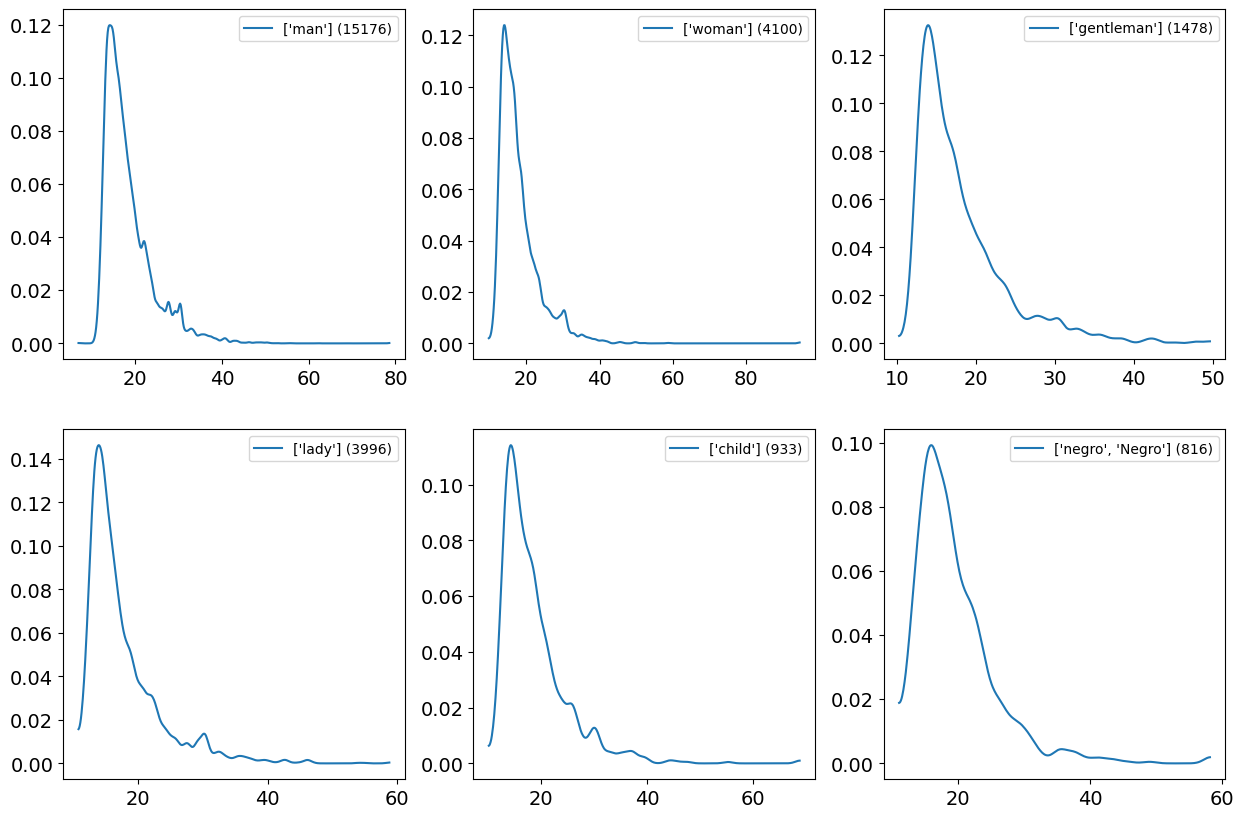

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, speakers in enumerate([["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["negro", "Negro"]]):
    row = i // 3
    col = i - (row)*3
    obs = get_by_speakers(quotes, speakers, (0,1))
    az.plot_kde(obs, ax=axs[row, col], label=f"{speakers} ({len(obs)})");


est. average ['man'] 18.335289764018686
est. average ['woman'] 17.98179814571306
est. average ['gentleman'] 17.97648927325116
est. average ['lady'] 17.586111947563634
est. average ['child'] 18.5974497379859
est. average ['negro', 'Negro'] 19.50090786852067


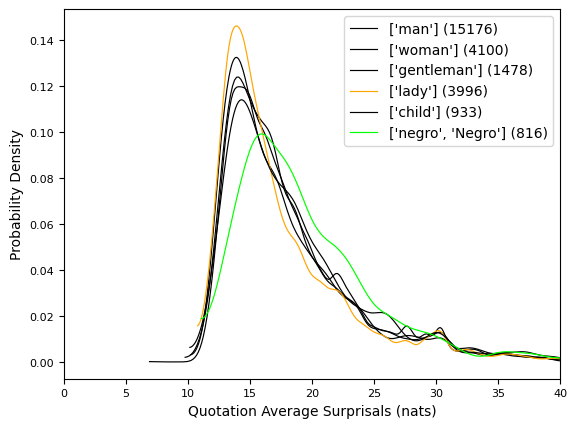

In [32]:
for i, (speaker, color) in enumerate([(["man"], "black"), (["woman"], "black"), (["gentleman"], "black"), (["lady"], "orange"), (["child"], "black"), (["negro", "Negro"], "lime")]):

    # 95% least surprising
    quotes.loc[(quotes.loc[:, "AvSur"]!=np.inf) & (quotes.loc[:, "speaker"].isin(speakers)), 'AvSur']
    mask = (quotes.loc[:, "speaker"].isin(speaker)) & (quotes.loc[:, "AvSur"]!=np.inf)

    # # ALL
    # mask = (quotes.loc[:, "AvSur"]!=np.inf) & (quotes.loc[:, "speaker"].isin(speaker) && (quotes.loc[:, "AvSur"] < np.quantile(quotes.loc[:, "AvSur"], 0.95)) )

    az.plot_kde(np.array(quotes.loc[mask, "AvSur"]), label=f"{speaker} ({sum(mask)})", textsize=8, plot_kwargs={'color':color});
    
    plt.xlabel("Quotation Average Surprisals (nats)")
    plt.ylabel("Probability Density")
    plt.xlim(0, 40)

    plt.savefig('RQ1_overlay')

    # est. means
    print("est. average", speaker, quotes.loc[mask, "AvSur"].mean())

## RQ1

In [33]:
# get the point estimate of the means
for speakers in [['negro', 'Negro'], ['man'], ['woman'], ['child'], ['gentleman'], ['lady']]:
    obs = get_by_speakers(quotes, speakers, (0,1))
    print(speakers, obs.mean())

['negro', 'Negro'] 19.50090786852067
['man'] 18.335289764018686
['woman'] 17.98179814571306
['child'] 18.5974497379859
['gentleman'] 17.97648927325116
['lady'] 17.586111947563634


15176 816
['man'] 1.1656181045019842
4100 816
['woman'] 1.5191097228076096
1478 816
['gentleman'] 1.524418595269509
3996 816
['lady'] 1.9147959209570367
933 816
['child'] 0.9034581305347693


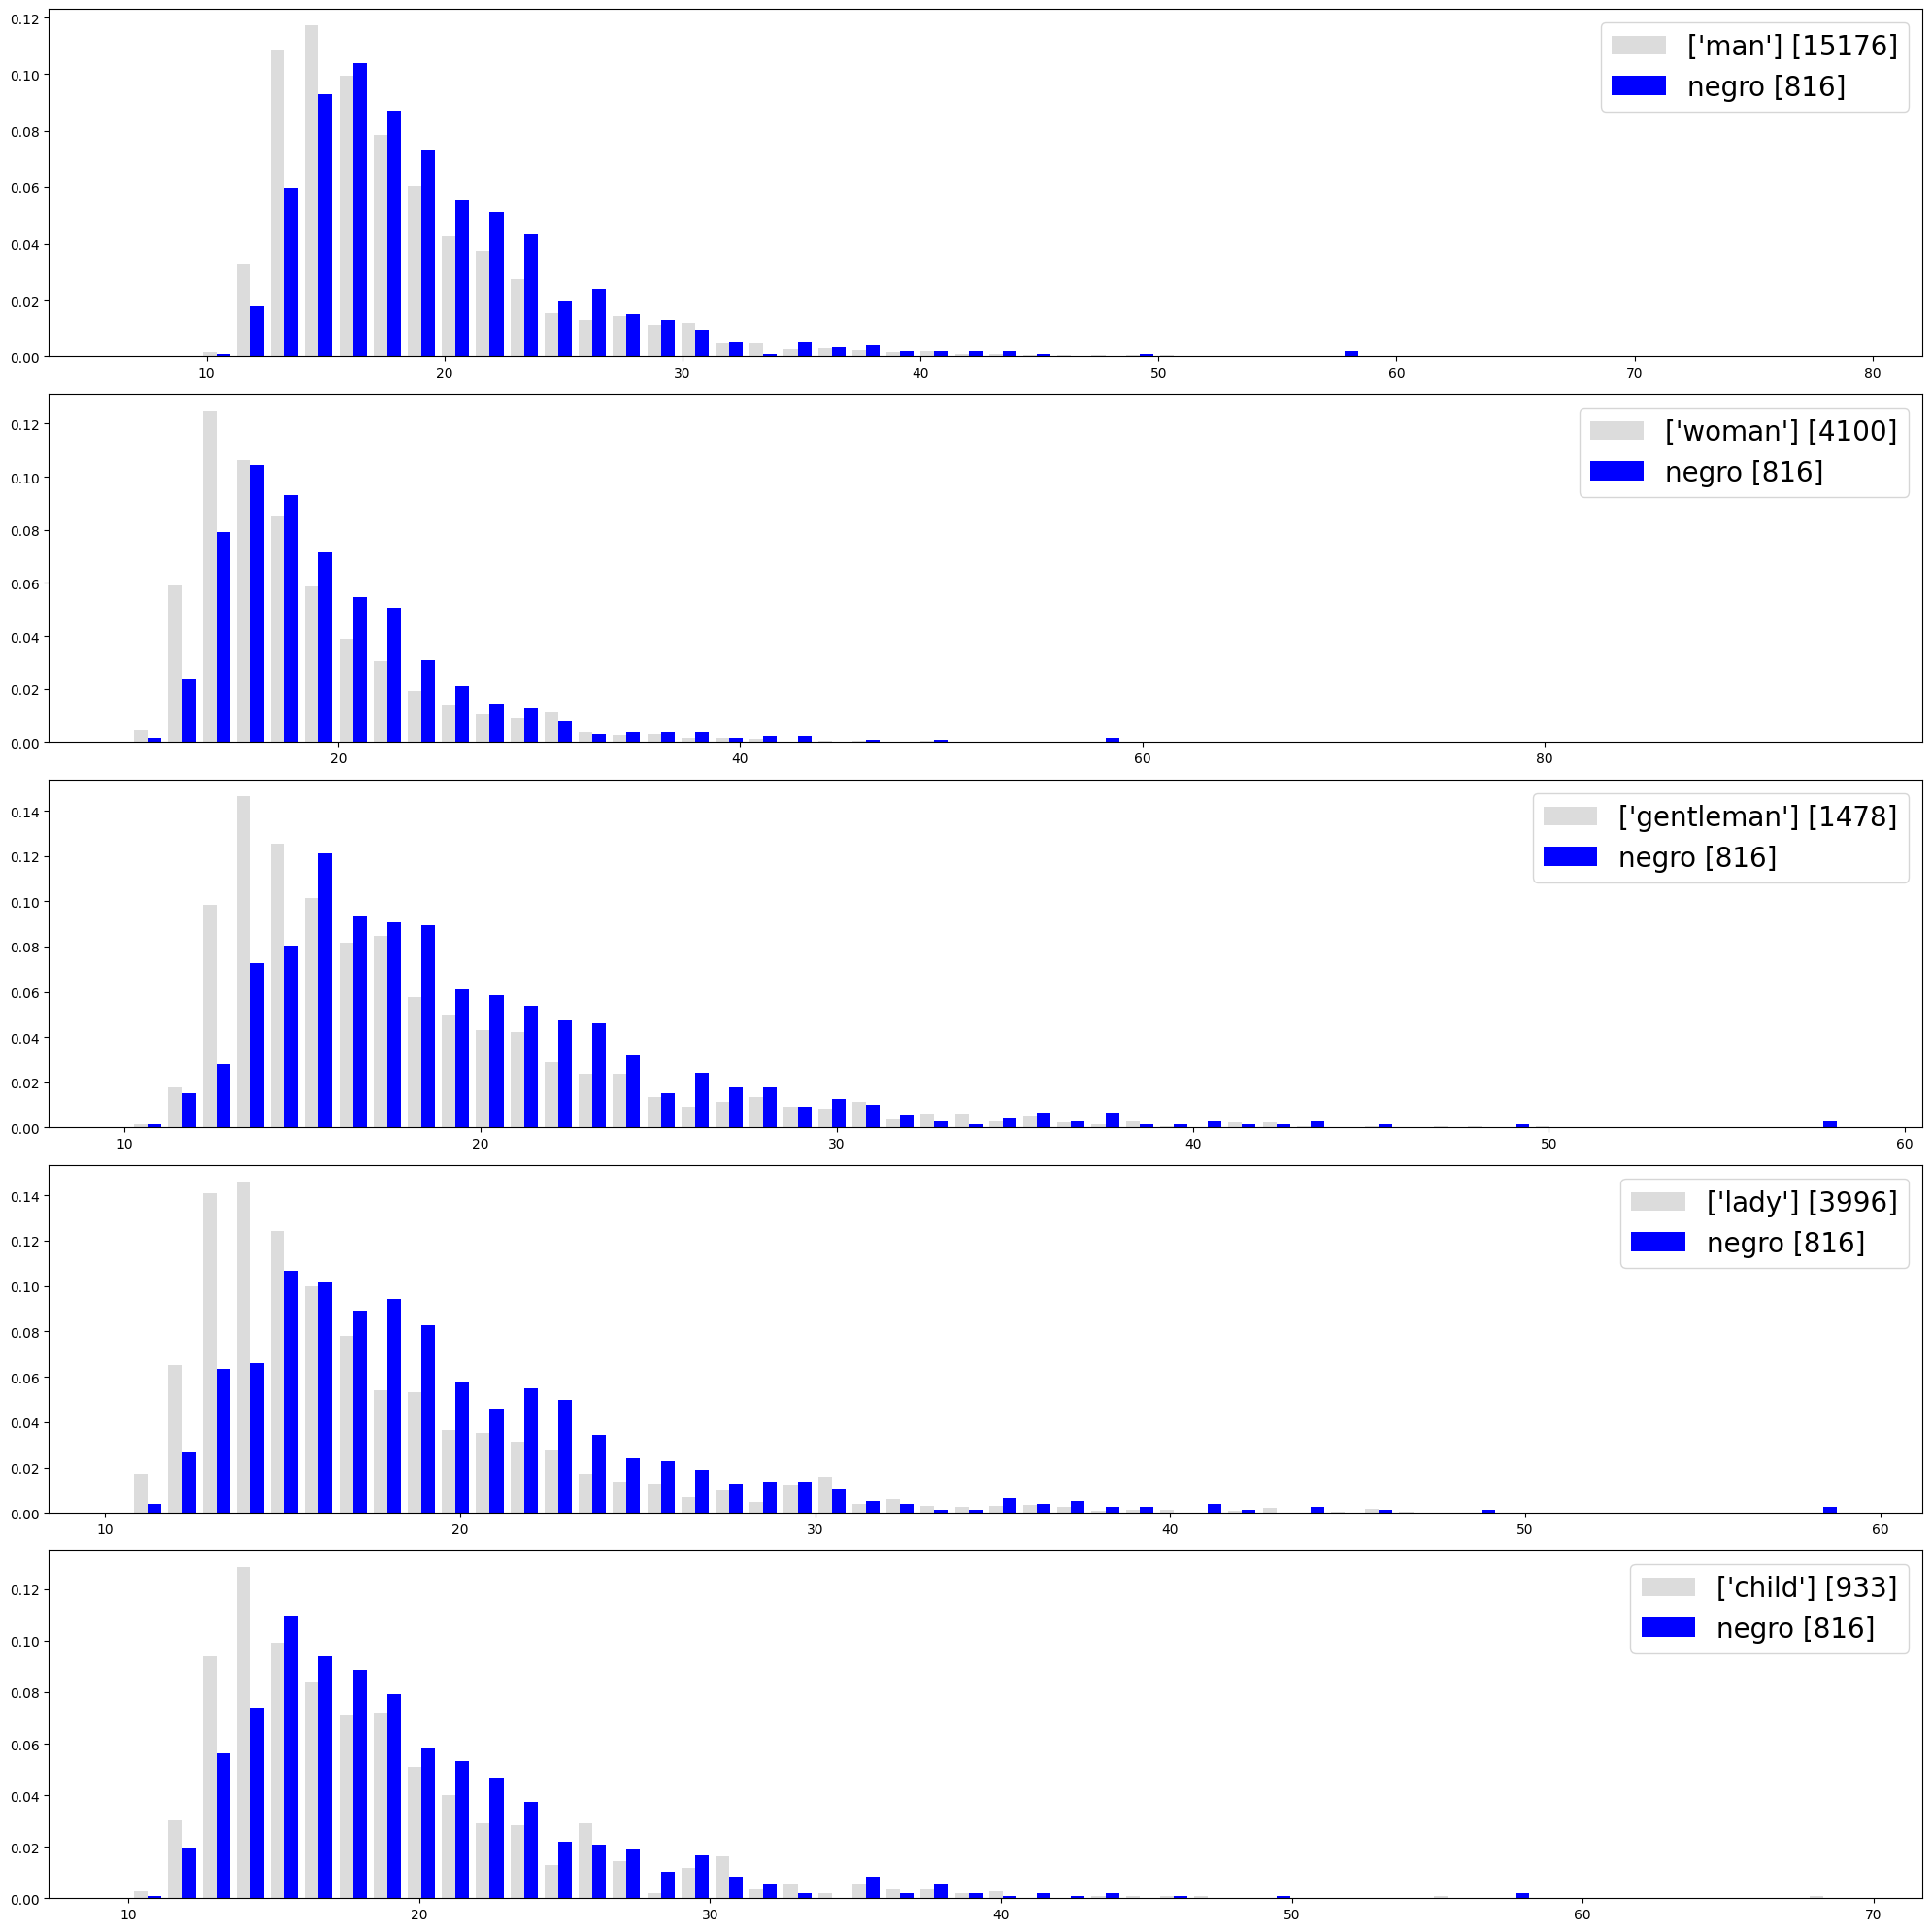

In [34]:
# plot histograms...

refs = [['man'], ['woman'], ['gentleman'], ['lady'], ['child']]
fig, axs = plt.subplots(len(refs), figsize=[20,20])

for i, ref in enumerate(refs):

    r = get_by_speakers(quotes, ref, (0,1))
    c = get_by_speakers(quotes, ['negro', 'Negro'], (0,1))

    print(len(r), len(c))

    # https://matplotlib.org/stable/gallery/color/named_colors.html
    axs[i].hist([r, c], density=True, bins=50, label = [f"{ref} [{len(r)}]", f'negro [{len(c)}]'], color=['gainsboro', 'blue']);
    axs[i].legend(fontsize=20)
    
    print(ref, c.mean() - r.mean())
    
plt.tight_layout()
plt.savefig("RQ1_histogram.jpg")
plt.show()


### comparison of means via BEST (depreciated)

As below ... we are struggling to find a 

In [32]:
from scipy.stats import norm

In [35]:
def skew_normal_mean(mu, sigma, alpha):
    # Compute the skewness factor delta
    delta = alpha / np.sqrt(1 + alpha**2)
    
    # Compute the mean of the skewed normal distribution
    mean_skewed = mu + sigma * delta * np.sqrt(2 / np.pi)
    
    return mean_skewed

def estimator(obs):
    with pm.Model() as model:
       
        mu = pm.Normal('mu', 0, 10)
        sigma = pm.HalfNormal('sigma', 10)
        alpha = pm.HalfNormal('alpha', 10)
        pm.SkewNormal("obs", mu=mu, sigma=sigma, alpha=alpha, observed=obs)
        trace=pm.sample()
        
    return model, trace

In [ ]:
# model each speaker quotation Average Surprisals
pm_out = {}
for speakers in [['Negro', 'negro'], ['man']]:#, ['woman'], ['child'], ['gentleman'], ['lady']]:
     
    obs = get_by_speakers(quotes, speakers, (0,1))
    pm_out[",".join(speakers)] = estimator(obs)

['Negro', 'negro']

(18.124350429742545, 18.868108240059954)

18.50010145393768

Sampling: [obs]


Output()

['man']

(17.37772405602673, 17.547841414947076)

17.380579702649726

Sampling: [obs]


Output()

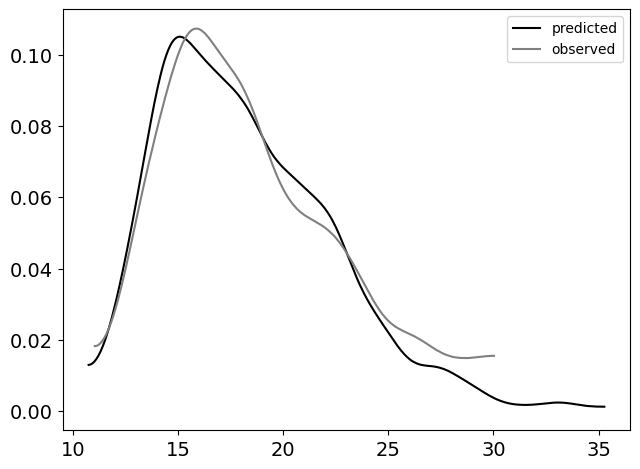

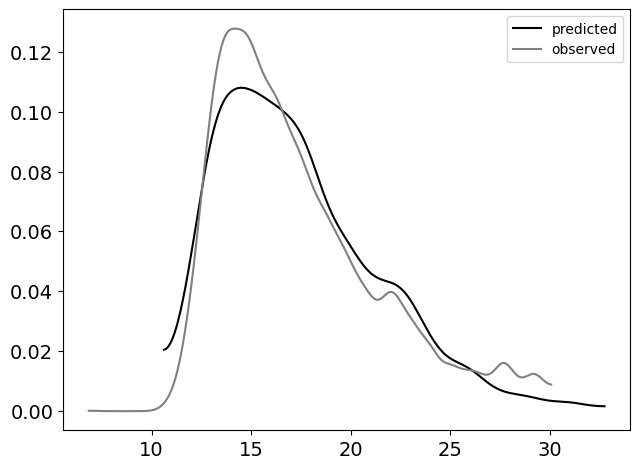

In [401]:
# let's take a look at one: 
for speakers in [['Negro', 'negro'], ['man']]:#, ['woman'], ['gentleman'], ['lady'], ['child']]:

    display(speakers)
    model, trace = pm_out[','.join(speakers)]
    obs = get_by_speakers(quotes, speakers, (0,1))
    # lb, ub = ge<t_hdi(obs_, hdi=0.99)
    # obs = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,metric]!=np.inf) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]

    
    # skew normal dist
    mu = trace.posterior['mu'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
    sigma = trace.posterior['sigma'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=cha4ins * draws
    alpha = trace.posterior['alpha'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=cha4ins * draws
    display(get_hdi(skew_normal_mean(mu, sigma, alpha), 0.99))
    display(obs.mean())
    
    # overlay
    plot_posterior_predictive_overlay(model, trace);
    # plot_posterior_estimates(trace);



In [443]:
# X = [['Negro', 'negro'], ['man'], ['woman'], ['gentleman'], ['lady'], ['child']]
# for i, speakers1 in enumerate(X[:-1]):
#     model1, trace1 = pm_out[','.join(speakers1)]
    
#     mu1 = trace1.posterior['mu'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
#     sigma1 = trace1.posterior['sigma'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
#     true_mu1 = log_normal_mean(mu1, sigma1)
    
#     for speakers2 in X[i+1:]:
#         model2, trace2 = pm_out[','.join(speakers2)]

#         mu2 = trace2.posterior['mu'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
#         sigma2 = trace2.posterior['sigma'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
#         true_mu2 = log_normal_mean(mu2, sigma2)

#         print(f"mu diff : {speakers1} - {speakers2} : {get_hdi(true_mu1 - true_mu2, 0.99)}")
        


### comparison of means via Bayesian Bootstrapping ...

i.e., we struggled to find a likelihood distribution that fit the data ....

In [37]:
def bayesian_bootstrapping(data1, data2, a=1, target_accept=0.8):
    """ Non-parameteric est. of the difference in distribution means.
    """
    with pm.Model() as model:
        
        w1 = pm.Dirichlet("w1", a=np.ones(len(data1))*a)
        w2 = pm.Dirichlet("w2", a=np.ones(len(data2))*a)
    
        mean1 = pm.Deterministic("mean1", pm.math.sum(w1 * data1))
        mean2 = pm.Deterministic("mean2", pm.math.sum(w2 * data2))
    
        # Difference in means
        mean_diff = pm.Deterministic("mean_diff", mean1 - mean2)
        diff_ratio = pm.Deterministic("diff_ratio", mean_diff/mean2)
    
        # Sample from the posterior
        trace = pm.sample(target_accept=target_accept)
        
    return model, trace

In [429]:
# az.plot_posterior(trace, var_names=["mean1", "mean2", "mean_diff"])
# az.summary(trace, var_names=["mean1", "mean2", "mean_diff"])


In [38]:
# every permutations of pairwise comparisons

pm_out = {}
X = [['Negro', 'negro'], ['man'],  ['woman'], ['gentleman'], ['lady'], ['child']]
for i, speakers1 in enumerate(X[:-1]):
    s1 = ','.join(speakers1)
    
    data1 = get_by_speakers(quotes, speakers1, (0,1))
    # data1 = np.random.choice(data1, size=min(1000, len(data1)))
    n1 = len(data1)

    for speakers2 in X[i+1:]:
        s2 = ','.join(speakers2)
        
        data2 = get_by_speakers(quotes, speakers2, (0,1))
        # data2 = np.random.choice(data2, size=min(1000, len(data2)))
        n2 = len(data2)
        
        model, trace = bayesian_bootstrappitng(data1, data2, a=3, target_accept=0.95)

        # record
        s = f"{s1}_minus_{s2}"
        pm_out[s] = (model, trace)

        # save trace
        az.to_netcdf(trace, f'{s}_TRACE.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w1, w2]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Output()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ValueError: Not enough samples to build a trace.

In [840]:
for key, (model, trace) in pm_out.items():
    print(key)
    display(az.summary(trace, var_names=["mean1", "mean2", "mean_diff", 'diff_ratio'], hdi_prob=0.99))
    # display(get_hdi(trace.posterior['mean_diff'].stack(sample=('chain', 'draw')).to_numpy(), 0.99))



Negro,negro_minus_man


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,19.433,0.120,19.135,19.719,0.002,0.001,3533.0,1752.0,1.0
mean2,18.252,0.027,18.175,18.315,0.000,0.000,4129.0,1436.0,1.0
mean_diff,1.181,0.124,0.880,1.487,0.002,0.001,3727.0,1691.0,1.0
diff_ratio,0.065,0.007,0.048,0.081,0.000,0.000,3746.0,1691.0,1.0


Negro,negro_minus_woman


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,19.433,0.119,19.141,19.755,0.002,0.001,5228.0,1553.0,1.0
mean2,17.841,0.046,17.727,17.956,0.001,0.001,3893.0,1727.0,1.0
mean_diff,1.592,0.128,1.285,1.949,0.002,0.001,4931.0,1705.0,1.0
diff_ratio,0.089,0.007,0.072,0.110,0.000,0.000,4894.0,1764.0,1.0


Negro,negro_minus_gentleman


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,19.433,0.120,19.130,19.735,0.002,0.001,3689.0,1817.0,1.0
mean2,17.888,0.086,17.689,18.109,0.001,0.001,4074.0,1492.0,1.0
mean_diff,1.545,0.149,1.143,1.912,0.002,0.002,3849.0,1675.0,1.0
diff_ratio,0.086,0.009,0.063,0.108,0.000,0.000,3880.0,1642.0,1.0


Negro,negro_minus_lady


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,19.430,0.121,19.136,19.735,0.002,0.001,3928.0,1662.0,1.0
mean2,17.461,0.049,17.344,17.600,0.001,0.001,3193.0,1455.0,1.0
mean_diff,1.969,0.128,1.649,2.283,0.002,0.001,3925.0,1765.0,1.0
diff_ratio,0.113,0.007,0.094,0.130,0.000,0.000,3923.0,1826.0,1.0


Negro,negro_minus_child


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,19.432,0.118,19.129,19.744,0.002,0.001,3922.0,1485.0,1.0
mean2,18.306,0.102,18.045,18.580,0.002,0.001,4389.0,1420.0,1.0
mean_diff,1.126,0.155,0.743,1.538,0.002,0.002,4225.0,1695.0,1.0
diff_ratio,0.062,0.009,0.042,0.086,0.000,0.000,4266.0,1724.0,1.0


man_minus_woman


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,18.251,0.025,18.194,18.316,0.000,0.000,4390.0,1867.0,1.0
mean2,17.841,0.048,17.718,17.962,0.001,0.001,3600.0,1668.0,1.0
mean_diff,0.410,0.054,0.254,0.532,0.001,0.001,3403.0,1614.0,1.0
diff_ratio,0.023,0.003,0.014,0.030,0.000,0.000,3420.0,1614.0,1.0


man_minus_gentleman


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,18.251,0.026,18.190,18.313,0.000,0.000,4053.0,1421.0,1.0
mean2,17.890,0.085,17.652,18.083,0.001,0.001,3878.0,1443.0,1.0
mean_diff,0.361,0.089,0.140,0.596,0.001,0.001,3759.0,1607.0,1.0
diff_ratio,0.020,0.005,0.008,0.034,0.000,0.000,3760.0,1607.0,1.0


man_minus_lady


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,18.252,0.026,18.186,18.313,0.000,0.000,3369.0,1449.0,1.0
mean2,17.461,0.052,17.341,17.601,0.001,0.001,4031.0,1713.0,1.0
mean_diff,0.791,0.058,0.638,0.934,0.001,0.001,3903.0,1598.0,1.0
diff_ratio,0.045,0.003,0.037,0.054,0.000,0.000,3895.0,1599.0,1.0


man_minus_child


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,18.252,0.027,18.186,18.319,0.000,0.000,4139.0,1687.0,1.0
mean2,18.309,0.106,18.045,18.565,0.002,0.001,3506.0,1647.0,1.0
mean_diff,-0.057,0.110,-0.327,0.209,0.002,0.002,3796.0,1480.0,1.0
diff_ratio,-0.003,0.006,-0.018,0.012,0.000,0.000,3816.0,1480.0,1.0


woman_minus_gentleman


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,17.841,0.048,17.710,17.976,0.001,0.001,3884.0,1585.0,1.0
mean2,17.890,0.086,17.673,18.133,0.001,0.001,3925.0,1570.0,1.0
mean_diff,-0.049,0.096,-0.292,0.203,0.001,0.002,4263.0,1578.0,1.0
diff_ratio,-0.003,0.005,-0.016,0.012,0.000,0.000,4266.0,1578.0,1.0


woman_minus_lady


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,17.842,0.050,17.714,17.978,0.001,0.001,4425.0,1557.0,1.0
mean2,17.462,0.051,17.330,17.584,0.001,0.001,4103.0,1582.0,1.0
mean_diff,0.380,0.072,0.183,0.556,0.001,0.001,3694.0,1470.0,1.0
diff_ratio,0.022,0.004,0.010,0.032,0.000,0.000,3695.0,1470.0,1.0


woman_minus_child


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,17.842,0.049,17.718,17.964,0.001,0.001,4055.0,1704.0,1.0
mean2,18.309,0.111,18.053,18.610,0.002,0.001,3691.0,1750.0,1.0
mean_diff,-0.466,0.121,-0.787,-0.172,0.002,0.001,4025.0,1774.0,1.0
diff_ratio,-0.025,0.006,-0.042,-0.010,0.000,0.000,4042.0,1774.0,1.0


gentleman_minus_lady


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,17.890,0.085,17.667,18.103,0.001,0.001,4495.0,1756.0,1.0
mean2,17.463,0.051,17.343,17.605,0.001,0.001,4701.0,1442.0,1.0
mean_diff,0.428,0.099,0.190,0.706,0.001,0.001,4491.0,1613.0,1.0
diff_ratio,0.025,0.006,0.009,0.038,0.000,0.000,4482.0,1614.0,1.0


gentleman_minus_child


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,17.891,0.083,17.665,18.087,0.001,0.001,3744.0,1446.0,1.0
mean2,18.306,0.103,18.031,18.559,0.002,0.001,3504.0,1347.0,1.0
mean_diff,-0.415,0.132,-0.750,-0.090,0.002,0.002,3449.0,1861.0,1.0
diff_ratio,-0.023,0.007,-0.041,-0.005,0.000,0.000,3448.0,1824.0,1.0


lady_minus_child


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,17.462,0.051,17.335,17.595,0.001,0.001,3668.0,1898.0,1.0
mean2,18.311,0.106,18.058,18.581,0.002,0.001,3965.0,1635.0,1.0
mean_diff,-0.849,0.118,-1.126,-0.539,0.002,0.001,3927.0,1667.0,1.0
diff_ratio,-0.046,0.006,-0.061,-0.030,0.000,0.000,3924.0,1639.0,1.0


## RQ2 

### Assemble dataframe of news quotations and corresponding surprisals

In [453]:
# load the quotes
with open("/home/ry/Projects/DH_Benelux2024_but_they_do_talk_a_bit_funny/LOC/tuples_news.json", "r") as f:
    tuples_news = json.load(f)

In [454]:
# load the chains
with open("/home/ry/Projects/DH_Benelux2024_but_they_do_talk_a_bit_funny/LOC/chains_llama3.1_news.json", "r") as f:
    chains_news = json.load(f)

In [456]:
# load the LOC quotes chains
display(len(chains_news))

1742

In [460]:
Q_news: pd.DataFrame = pd.DataFrame({"quote":quotes_news})

In [464]:
Q_news['i'] = list(range(len(quotes_news)))

In [465]:
Q_news["words"] = Q_news["quote"].progress_apply(lambda x: get_words(x))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1742/1742 [00:00<00:00, 11962.83it/s]


In [466]:
Q_news['N'] = Q_news['words'].progress_apply(lambda x: len(x))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1742/1742 [00:00<00:00, 200529.08it/s]


In [467]:
Q_news["sumNLL"] = Q_news["i"].progress_apply(lambda i: -np.log(chains_news[i]).sum())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1742/1742 [00:00<00:00, 83968.99it/s]


In [468]:
Q_news["AvSur"] = Q_news["sumNLL"]/Q_news["N"]

In [477]:
Q_news['speaker'] = 'negro'

### comparison of means via Bayesian Bootstrapping

In [756]:
nword_lit = get_by_speakers(quotes, ['negro', 'Negro'], (0,1))
nword_news = get_by_speakers(Q_news, ['negro'], (0,1))

model, trace = bayesian_bootstrapping(nword_lit, nword_news, a=3, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w1, w2]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Output()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 359 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [757]:
display(az.summary(trace, var_names=["mean1", "mean2", "mean_diff", "diff_ratio"], hdi_prob=0.99))


,mean,sd,hdi_0.5%,hdi_99.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean1,19.434,0.121,19.114,19.737,0.002,0.001,3542.0,1488.0,1.0
mean2,17.024,0.079,16.823,17.228,0.001,0.001,3958.0,1495.0,1.0
mean_diff,2.409,0.144,2.055,2.769,0.002,0.002,4043.0,1512.0,1.0
diff_ratio,0.142,0.009,0.120,0.163,0.000,0.000,4004.0,1615.0,1.0


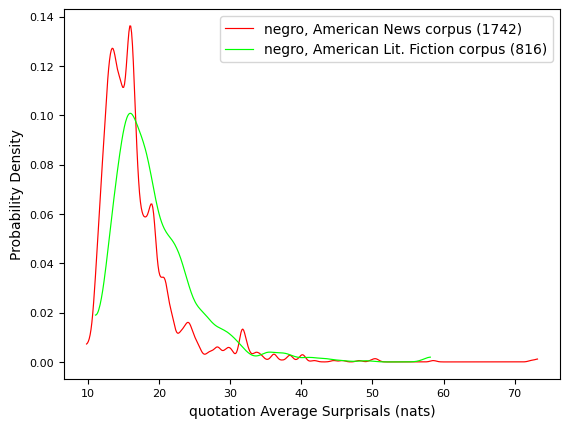

In [664]:
# overlays of quotation Average Surprisal for lit vs news

az.plot_kde(np.array(Q_news.loc[:, "AvSur"]), label=f"negro, American News corpus ({len(nword_news)})", textsize=8, plot_kwargs={'color':"red"});
az.plot_kde(np.array(quotes.loc[quotes.loc[:, 'speaker'].isin(['negro', 'Negro']), "AvSur"]), label=f"negro, American Lit. Fiction corpus ({len(nword_lit)})", textsize=8, plot_kwargs={'color':"lime"});
# az.plot_kde(np.array(quotes.loc[quotes.loc[:, 'speaker'].isin(['lady']), "AvSur"]));

plt.ylabel("Probability Density")
plt.xlabel("quotation Average Surprisals (nats)")
plt.savefig("RQ2_overlaid")
plt.show()

"I begs marsterâs pardon berry much,"
"Oh, yes, marster, heâll do it easy,"
"Iâm in a great hurry; goinâ arter the doctor for ole miss, whoâs sartin sheâs goinâ for to die this time."
"Dun know, unless itâs Bobaway,"
"Ye-es, mis-s, CÃ¦s--he--done been to party fore now. Git 'long dar, Sorrel,"
WE INTEND TO MAKE VIRGINIA DRINK NEGRO SUFFRAGE — BROAD AS THE EARTH, HIGH AS HEAVEN, AND DEEP AS HELL.
—New YorkHerald.HALF A CONVERSATIONYassir.


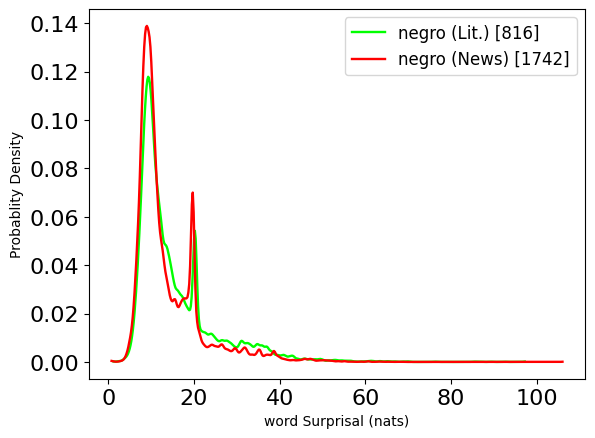

In [760]:
# # overlays of word Surprisal for lit vs news

# speakers, color = (["negro", "Negro"], "lime")
    
# i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
# surprisals_lit = []

# for i in i_of_interest:
#     try:
#         c = np.array(chains[i])
#         q = quotes.loc[i, 'quote']
#         s  = q[1:-1]
#         words = get_words(s)
#         tokens = np.array(tokenizer.tokenize(s))
#         words_indices, N = get_words_indices(words, tokens)
    
#         for word, word_indices in zip(words, words_indices):
#             word_surprisal = -np.log(c[word_indices]).sum()
#             surprisals.append([word, word_surprisal])
#     except:
#         print(q)
        
# surprisals_lit = sorted(surprisals, key = lambda x: x[1], reverse=True)
# az.plot_kde(np.array([x[1] for x in surprisals_lit]), label=f"negro (Lit.) [{len(i_of_interest)}]", textsize=16, plot_kwargs={'color':color});

# # ------
# # negro, news
# # ------


# i_of_interest = Q_news.loc[:, 'i']

# color = 'red'

# # get surprisals over words
# surprisals_news = []
# for i in i_of_interest:
#     c = np.array(chains_news[i])
#     q = Q_news.loc[i, 'quote']
#     s  = q
#     words = get_words(s)
#     tokens = np.array(tokenizer.tokenize(s))
#     try:
#         words_indices, N = get_words_indices(words, tokens)
#         for word, word_indices in zip(words, words_indices):
#             word_surprisal = -np.log(c[word_indices]).sum()
#             surprisals_news.append([word, word_surprisal])

#     except:
#         print(s)
        
# surprisals_news = sorted(surprisals_news, key = lambda x: x[1], reverse=True)
# az.plot_kde(np.array([x[1] for x in surprisals_news]), label=f"negro (News) [{len(i_of_interest)}]", textsize=16, plot_kwargs={'color':color});


# plt.legend(fontsize=12) #, loc='upper left', frameon=True, facecolor='lightgray', edgecolor='black')
# plt.ylabel("Probablity Density", )
# plt.xlabel("word Surprisal (nats)")
# plt.savefig("RQ2_word_level_overlay")

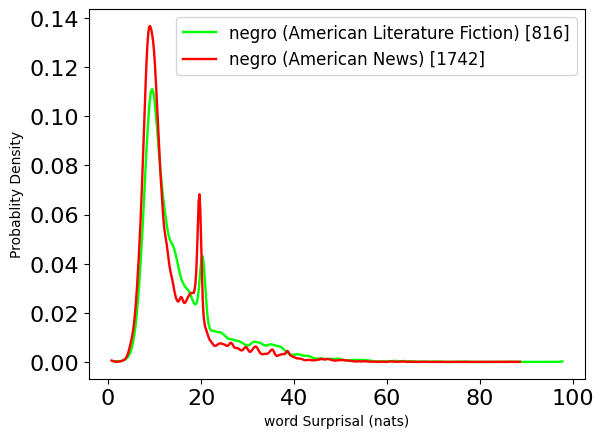

In [1189]:
# overlays of word Surprisal for lit vs news

speakers, color = (["negro", "Negro"], "lime")
    
i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
surprisals_lit = []

for i in i_of_interest:
    try:
        c = np.array(chains[i])
        q = quotes.loc[i, 'quote']
        s  = q[1:-1]
        words = get_words(s)
        tokens = np.array(tokenizer.tokenize(s))

        found = set()
        for word in set(words):
            for word_indices in gen_word_indices(word, tokens):
                word_surprisal = -np.log(c[word_indices]).sum()
                surprisals_lit.append([word, word_surprisal])
                found.add(word)
        # print(i, set(words) - found)
    except:
        print(i, quotes.loc[i, 'quote'])
        
surprisals_lit = sorted(surprisals_lit, key = lambda x: x[1], reverse=True)
# print(surprisals_lit)
az.plot_kde(np.array([x[1] for x in surprisals_lit]), label=f"negro (American Literature Fiction) [{len(i_of_interest)}]", textsize=16, plot_kwargs={'color':color});

# ------
# negro, news
# ------


i_of_interest = Q_news.loc[:, 'i']

color = 'red'

# get surprisals over words
surprisals_news = []
for i in i_of_interest:
    try:
        c = np.array(chains_news[i])
        q = Q_news.loc[i, 'quote']
        s  = q
        words = get_words(s)
        tokens = np.array(tokenizer.tokenize(s))

        found = set()
        for word in set(words):
            for word_indices in gen_word_indices(word, tokens):
                word_surprisal = -np.log(c[word_indices]).sum()
                surprisals_news.append([word, word_surprisal])
                found.add(word)
        # print(i, set(words) - found)

    except:
        print(i, Q_news.loc[i, 'quote'])
        
surprisals_news = sorted(surprisals_news, key = lambda x: x[1], reverse=True)
az.plot_kde(np.array([x[1] for x in surprisals_news]), label=f"negro (American News) [{len(i_of_interest)}]", textsize=16, plot_kwargs={'color':color});


plt.legend(fontsize=12) #, loc='upper left', frameon=True, facecolor='lightgray', edgecolor='black')
plt.ylabel("Probablity Density", )
plt.xlabel("word Surprisal (nats)")
plt.savefig("RQ2_word_level_overlay")

In [994]:
with open("/usr/share/dict/words", "r") as f:
    en_words = [x.strip("\n") for x in f.readlines()]
en_words += [w.capitalize() for w in en_words]
en_words = set(en_words)

In [1192]:
# let's look at the relative proportion of out of dictionary words beyond 19 nats ..
display(len([word for word, surprisal in surprisals_lit if any(set(word).intersection(string.ascii_letters))]))  ## total words
display(len([word for word, surprisal in surprisals_lit if word not in en_words])) # total out of dict words

display(len([word for word, surprisal in surprisals_news if any(set(word).intersection(string.ascii_letters))]))  ## total words
display(len([word for word, surprisal in surprisals_news if word not in en_words])) # total out of dict words

11316

5188

22511

8258

In [1193]:
display(5188/11316)
display(8258 / 22511)

0.45846588900671614

0.36684287681577893

##RQ3


In [561]:
# load a dict
with open("/usr/share/dict/words", "r") as f:
    en_words = [x.strip("\n") for x in f.readlines()]

en_words += [w.capitalize() for w in en_words]

en_words = set(en_words)

Let's take a look at the n-word, lit quoations split into quotaiton Surprisal Bands ... do we observe ...

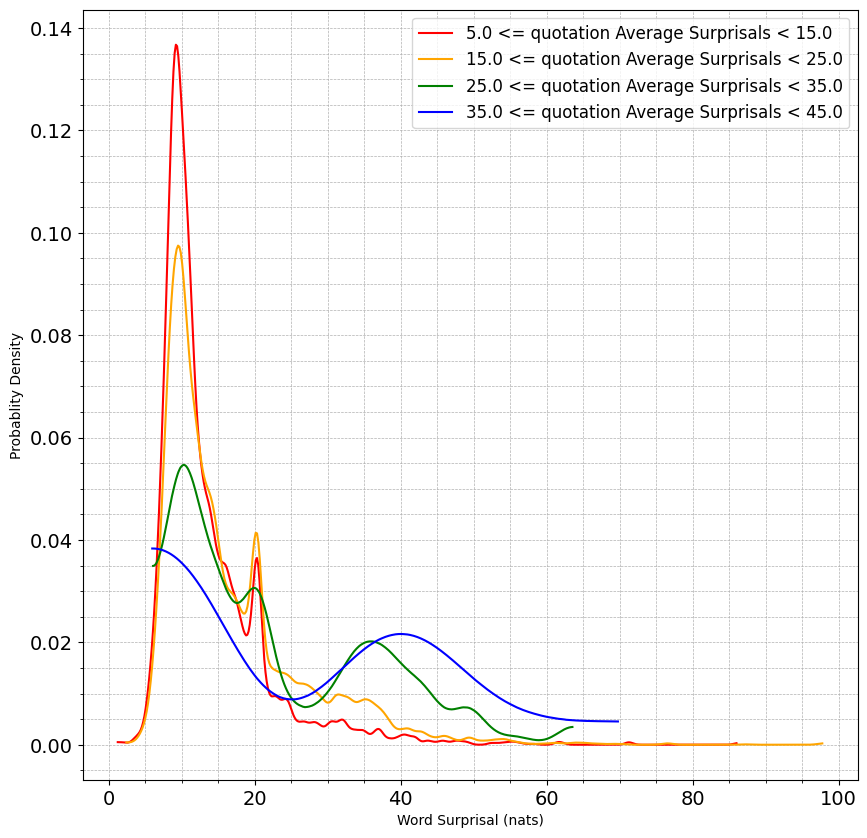

In [1210]:

plt.figure(figsize=(10, 10))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)

colors = ['red', 'orange', 'green', 'blue', 'indigo']

# consider bands of Quotation Average Surprisals ... 

step = 5
bin_width=10
for k, bin_mid in enumerate([10, 20, 30, 40]):

    i_of_interest = get_i_by_speakers(quotes, ['negro', 'Negro'], (0,1))
    i_of_interest = quotes.loc[(quotes.loc[:,'i'].isin(i_of_interest)) & (quotes.loc[:, 'AvSur'] >= bin_mid - bin_width/2 ) & (quotes.loc[:,'AvSur'] < bin_mid + bin_width/2), 'i']

    surprisals = []
    for i in i_of_interest:
        
        try:
            q = quotes.loc[i, 'quote']
            c = np.array(chains[i])
            s  = q[1:-1]
            words = get_words(s)
            tokens = np.array(tokenizer.tokenize(s))

            for word in set(words):
                for word_indices in gen_word_indices(word, tokens):
                    word_surprisal = -np.log(c[word_indices]).sum()
                    surprisals.append(word_surprisal)
                    found.add(word)

        except:  # something gone wrong? let's take a look
            print(i, quotes.loc[i, 'quote'])
                
    surprisals = np.array(surprisals)
    az.plot_kde(surprisals, plot_kwargs={'color':colors[k]}, label=f"{bin_mid - bin_width/2} <= quotation Average Surprisals < {bin_mid + bin_width/2}");

plt.legend(fontsize=12) #, loc='upper left', frameon=True, facecolor='lightgray', edgecolor='black')
plt.ylabel("Probablity Density", )
plt.xlabel("Word Surprisal (nats)")
plt.savefig("RQ3_word surprisal by quotations surprisal bands")
plt.show()


## RQ3       

### Sampling n-word quotations, to identify common variations and explore ripple effect

i) report the kinds of variation in there, in their relative quantities

    annotate a random sample in regards observed variations

ii) consider the secondary effect of variations on contextual Surprisal

    use the above annotations

    for variation type in variation types observed and annotated:       
    
        R = bag of Surprisals pertaining to sampled quotations, when removed of words demonstrative of variation, v
        C = bag of Surprisals pertaining to sampled quotations, when corrected of variation type, v

    unaccounted for secondary effect = (mean(C) - mean(R)) / mean(R)

#### i) explore the variations

get the CMU lines as a dict for quickly searching, for annotating

In [39]:
# Load the CMU pronunciation dictionary
import requests
lines = requests.get("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b").text.splitlines()

# ignore eveything up the 'A  AH0'
lines = lines[lines.index('A  AH0'):]

k_l = [(line.split(" ")[0].split("(")[0], line) for line in lines]
cmu = defaultdict(list)
for line in lines:
    key = line.split(" ")[0].split("(")[0]
    pron = line.split(" ")[1:]
    cmu[key.lower()].append(pron)
    

In [40]:
cmu["rudder"]

[['', 'R', 'AH1', 'D', 'ER0']]

In [41]:
cmu["others"]

[['', 'AH1', 'DH', 'ER0', 'Z']]

get a sample

In [42]:
sample_fn = "annotated_sample.json"

In [1342]:
# sample_i = [i  for i in np.random.choice(quotes.loc[quotes.loc[:,'speaker'].isin(['negro', 'Negro']), "i"], size=500)]
# sample = [(quotes.loc[i, 'quote'][1:-1], quotes.loc[i, 'quote'][1:-1], int(i)) for i in sample_i]
# with open(sample_fn, "w") as f:
#     json.dump(sample, f)


let's do a simple check for errors

In [43]:
# load the sample and get all annotations
with open(sample_fn, "r") as f:
    annotations = json.load(f)

for original, annotated, i in annotations:
    if annotated.count('#') % 4 != 0:
        print(i)

let's look at the annotations

In [44]:

found = []
for original, annotated, i in annotations[:40]:  # first 40 have been annotated
    for x in re.findall("#[^#]*#[^#]*#[^#]*#", annotated):
        found.append((i,x))

print(len(set([i for i,x in found])))

# ordered by original word
for i,x in sorted(found, key = lambda x: x[1].split('#')[1]):
    print(i,x)

# # reverse order
# for i,x in found[::-1]:
#     print(i,x)

32
331 #'bout#about#dropped AH0 at start#
7834 #'bout#about#dropped A at start#
22406 #'em#them#dropped TH at beginning#
24620 #'em#them#dropped DH at start#
10993 #'fernal#infernal#dropped IH2_N at start#
17329 #'im#him#dropped H at start#
9145 #'pinion#opinion#dropped AH0 start#
10459 #'teak#steak#dropped S at start#
20092 #'way#away#dropped AH0 from start#
22406 #<MISSING>#have#missing aux verb#
24620 #<MISSING>#is#missing linking verb#
24353 #<MISSING>#as#missing conjunction#
24353 #<MISSING>#are#missing linking verb#
24421 #<MISSING>#are#missing verb#
331 #<MISSING>#a#missing determiner, missing indefinite article#
7834 #Ah#I#AY1->AA1#
331 #An'#end#dropped D at end#
22406 #Dat#That#th->d#
331 #Den#Then#DH->D#
330 #Dis#This#DH->D#
14999 #Feedin'#Feeding#dropped g at end#
9145 #Giner'l#General#EH1->IH1,dropped AH0#
6803 #I'se#I am#non--standard contraction#
9145 #Injun#Indian#D->JH, IY0_AH0->AH1#
6803 #Mars'#Master#dropped T_ER0 from end#
6803 #Mars'#Master#dropped T_ER0 from end#
2

what variation types do we observe? 

In [2078]:
from collections import Counter
type_count = Counter()
type2instances = defaultdict(list)
type2i = defaultdict(list)
for i,x in found:
    instance, correction, labels = x.split("#")[1:-1]

    # populate type_count
    type_count.update([_.strip() for _ in labels.split(",")])

    # populate type2instances
    for t in [_.strip() for _ in labels.split(",")]:
        type2instances[t].append(instance)

    # populate type2i
    for t in [_.strip() for _ in labels.split(",")]:
        type2i[t].append(i)


In [2080]:
count = 0
for v, freq in type_count.most_common():
    print(v, freq, set(type2instances[v]))
    count += 1
count

DH->D 37 {'dey', 'dem', 'dar', 'dis', 'dat', 'dese', 'deze', 'Dis', 'Den', 'de', 'den'}
dropped R at end 23 {'sho', 'Mistuh', 'sah', 'ovah', 'yo', "yo'", 'wha', 'Yassah!', 'massa', 'Massa', 'heah', 'suh'}
dropped D at end 15 {"An'", 'wile', "worl'", "an'", 'mine'}
dialect word 12 {'Tankee', 'outen', 'gwine', 'ergwine', 'thankee', 'gin', 'agwine'}
EH1->IH1 7 {'git', 'mistis', "Giner'l", "gittin'"}
dropped R 7 {'mistis', "f'om", 'hoss', "heah'd", 'pusson', 'fust', 'suh'}
EH1_R->AH1 7 {'wha', 'suh'}
UW1->AH1 7 {'yu'}
UH1_R->OW1 5 {'yo', 'sho', "yo'"}
dropped G at end 5 {"nothin'", "Nothin'", "goin'", "gittin'", "takin'"}
AH0->AH1 5 {'plantashun', 'membrunces', 'und'}
V->B 5 {'ober', 'eber', 'gib'}
TH->D 5 {'wid', "fader's", 'dat', 'fortwid'}
dropped T 4 {"cap'en", 'Massa', 'genermen'}
ER0->AE1 4 {'massa', 'Massa'}
dropped T at end 4 {"mos'", "greates'", 'jes'}
ER1->AH1 3 {'wuth', 'fust', 'pusson'}
AH1->EH1 3 {'jes', 'jest'}
EH1->AA1 3 {'whar', 'dar'}
AO1_R->ER1 3 {'fur', 'yer'}
EY1->EH1 3

114

#### ii) quantify the secondary effect of variations: 

i.e., measure by how much the true effect of each variation is underestimated by our estimation approach

#### for selected types, get a sample set of corrected quotations

useful bits of code

In [1587]:
# test
"#crick#creek#IY1->IH1#".split("#")  # original = split[1], corrected = split[2]

['', 'crick', 'creek', 'IY1->IH1', '']

In [1593]:
# test
list(re.finditer(r"#[^#]*#[^#]*#", "are you going to #hel'#help# me now?"))  # index 28 is the char after the match

[<re.Match object; span=(17, 28), match="#hel'#help#">]

In [1598]:
# test
list(re.finditer(r"#[^#]*#[^#]*#", "are you going to #hel'#help# me now?"))[0].span()  # span() yields from:to indices of slice

(17, 28)

In [1601]:
annotations[0]

['Dis arternoon,', '#Dis#This#DH->D# #arternoon#afternoon#F->R#,', 330]

selected variation types

In [2086]:
# V = ['DH->D', 'dropped R at end', 'EH1_R->AA1', 'dropped R', 'dialect word', 'UH1_R->OW1', 'dropped end', 'EH1->IH1', 'dropped g at end', 'dropped D at end']
V = [v for v in set(type_count.keys()) if 'missing' not in v and v != '']
V

['UW1->OW1',
 'dropped AH0 at start',
 'AH01_R->OW1',
 'TH->d',
 'IH1->EH1',
 'UH1->AO1',
 'IY0_AH0->AH1',
 'H->Y',
 'dropped F at end',
 'dropped S at start',
 'AH0->AH1',
 'AH1->A01',
 'DH->DD',
 'EY1->IH1',
 'dropped AH0',
 'AO1_R->OW1',
 'ER0->ER1',
 'dropped R at end',
 'dropped TH at beginning',
 'IY1->IH1',
 'AY1->AA1',
 'K_S->S',
 'UH1_R->OW1',
 'D->JH',
 'TH->F',
 'dropped S at end',
 'added s at end',
 'non--standard contraction',
 'dialect word',
 'ER1->AH1',
 'AE1->IH1',
 'IY1->EH1',
 'dropped T_ER0 from end',
 'ER0->AE1',
 'dropped T',
 'UW1->AH1',
 'AE1->AA1_R',
 'AH0->ER1',
 'AO1->EY1',
 'IH0_K->S',
 'AH0->IH1',
 'S_K->K_S',
 'misspell',
 'a-',
 'F->R',
 'AH0->EH1',
 'ER0->AH0',
 'dropped IH2_N at start',
 'dropped AH0 from start',
 'dropped G at end',
 'ER1->IY1',
 'dropped D at end',
 'EH1->AE1',
 'dropped IYO at end',
 'dropped d at end',
 'S_K->K_S_IH2_Z',
 'er',
 'AH1->EH1',
 'dropped H at start',
 'droppped G at end',
 'dropped D',
 'ER1->AA1',
 'EH2_R->ER1',
 'EY1

#### for each variation, get the sample subset of quotes, with variation corrected

In [2087]:
# load the sample and get all annotations
with open(sample_fn, "r") as f:
    annotations = json.load(f)

corrected_quotes = []  # list of quotes with each variation corrected
corrected = []  # changes needed
corrections = []  # changes made 

for v in V:

    I = set(type2i[v])  # all the quotation i values, containing at least one example of the variation

    # consider the quotation samples whose i is in I
    for original, annotated, i in annotations[:20]:
        if i in I:

            corrections.append([])
            corrected.append([])
    
            # record [original word, corrected word, from_, to_] for all amendments (whether v or not)
            X = []
            for match in re.finditer(f"#[^#]*#[^#]*#[^#]*#", annotated):
                from_, to_ = match.span()
                match_split = annotated[from_:to_].split("#")
                o = match_split[1]
                c = match_split[2]
                v_ = match_split[3]
                X.append([o, c, v_, from_, to_])
    
            # make the corrections to the quotation and record teh corrected quotation
            p = annotated
            
            # make coincident changes in reverse order
            for o, c, v_, from_, to_ in sorted(X, key=lambda _:_[3], reverse=True):
                if v in v_:
                    p = p[:from_] + c + p[to_:]
                    corrections[-1].append(c)
                    corrected[-1].append(o)
                else:
                    p = p[:from_] + o + p[to_:]
        
            #remove <MISSING>
            p = p.replace(" <MISSING>", "")
    
            corrected_quotes.append((p, i, v))
        
# save corrected and corrections
with open('RQ3_corrected_quotes.json', 'w') as f:
    json.dump(corrected_quotes, f)

with open('RQ3_corrections.json', 'w') as f:
    json.dump(corrections, f)

with open('RQ3_corrected.json', 'w') as f:
    json.dump(corrected, f)

In [1933]:
# let's look at the corresponding corrected & corrections
list(zip(corrected_quotes, corrected, corrections))

[(('This arternoon,', 330, 'DH->D'), ['Dis'], ['This']),
 (('Will we bofe git on the hoss?', 20840, 'DH->D'), ['de'], ['the']),
 (("yas, I thankee, sah, fur I jest wanted ter be satisfied in my mine, an' I tell you dat when er pusson is troubled in his mine he's outen fix sho nuff. Hurry up there, Tildy, wid you snack, fur these genermen is a-haungry.",
   14094,
   'DH->D'),
  ['deze', 'dar'],
  ['these', 'there']),
 (("Hi, Marse Capping! who you think is a 'fernal fool? Not this Joe,",
   10993,
   'DH->D'),
  ['dis'],
  ['this']),
 (("Well, suh! You put all that down, an' it didn't take you no time; no, suh, not no time. But I might uv speckted it, bekase I hear lots er talk about how smart you is on all sides--they all sesso.",
   10344,
   'DH->D'),
  ['dey', 'dat'],
  ['they', 'that']),
 (("Why, massa! gracious, that what Massa Whaley give all he cap'en, an' he tink 'em fust-rate,",
   24620,
   'DH->D'),
  ['dat'],
  ['that']),
 (('I hope she may be jes es happy es the larks dow

#### let's examine the ripple affect ...

In [2088]:
## load ...

# Note: each entry in the following files, corresponds directly with one another

# load the chains of the amended permutations
with open("RQ3_corrected_chains_llama3.1_70B.json", "r") as f:
    corrected_chains = json.load(f)
    print(len(corrected_chains))

# load the corrected quotations 
with open("RQ3_corrected_quotes.json", "r") as f:
    corrected_quotes = json.load(f)
    print(len(corrected_quotes))

# load the corrected quotations 
with open("RQ3_corrections.json", "r") as f:
    corrections = json.load(f)
    print(len(corrections))

# load the list of amendents, corrected in each permutation
with open("RQ3_corrected.json", "r") as f:
    corrected = json.load(f)
    print(len(corrected))

100
100
100
100


In [2093]:
# we're interested in the elevated contextual surprisal outside of the corrections ...

est_ripple_effect = []

for (corrected_quote, i, variation), corrections_, corrected_, corrected_chain in zip(corrected_quotes, corrections, corrected, corrected_chains):

    # get list of word indices which do not contain the variation
    word_indices_of_interest = []
    original_tokens = tokenizer.tokenize(quotes.loc[i, 'quote'][1:-1])
    original_words = get_words(quotes.loc[i, 'quote'][1:-1])
    for j, word in enumerate(original_words):
        if word not in corrected_:
            word_indices_of_interest.append(j)
    word_indices_of_interest = set(word_indices_of_interest)

    # collect the Surprisal by word, for the words of interest in the original quote
    c = np.array(chains[i])
    original_peripheral_surprisals = []
    original_tokens = tokenizer.tokenize(quotes.loc[i, 'quote'][1:-1])
    original_words = get_words(quotes.loc[i, 'quote'][1:-1])
    for j, word in enumerate(original_words):
        if j in word_indices_of_interest:            
            for word_indices in gen_word_indices(word, original_tokens):
                s = -np.log(c[word_indices]).sum()
                original_peripheral_surprisals.append(s)
    original_peripheral_surprisals = np.array(original_peripheral_surprisals)

    # collect the Surprisal by word, for the words of interest in the original quote
    c = np.array(corrected_chain)
    corrected_peripheral_surprisals = []
    corrected_tokens = tokenizer.tokenize(corrected_quote)
    corrected_words = get_words(corrected_quote)
    for j, word in enumerate(corrected_words):
        if j in word_indices_of_interest:            
            for word_indices in gen_word_indices(word, corrected_tokens):
                s = -np.log(c[word_indices]).sum()
                corrected_peripheral_surprisals.append(s)
    corrected_peripheral_surprisals = np.array(corrected_peripheral_surprisals)

    # get percentage increase in quotation average surprisal, due to elevated surprisal of words peripheral to  variation instances
    if len(original_peripheral_surprisals) == len(corrected_peripheral_surprisals):
        x = 100*(original_peripheral_surprisals - corrected_peripheral_surprisals).sum() / original_peripheral_surprisals.sum() / len(original_peripheral_surprisals)
        est_ripple_effect.append(x)

print(get_hdi(est_ripple_effect, 0.95))  # percent
print(np.array(est_ripple_effect).mean())

(-5.398821673065054, 2.8434418513734974)
0.42593029944853317


## RQ3: Average Surprisal contribution by *class* of eye - dialect

generally useful functions ...

In [810]:
def gen_indices(reference:list[str], find: list[str])->typing.Generator:
    """ Return the slice lb and ub of the 'reference' array, that share the same elements of the 'find' array
    """
    for i in range(len(reference) - len(find)+1):
        if reference[i:i+len(find)] == find:
            yield (i,i+len(find))

In [1318]:
list(gen_indices(['hello', 'my', 'friend', 'hello', '.'], ['hello', 'my']))

[(0, 2)]

In [1259]:
def find_all_indices(word, substring):
    indices = []
    start = 0
    while True:
        start = word.find(substring, start)
        if start == -1:
            break
        indices.append(start)
        start += len(substring)  # Move past the last found index
    return indices

In [1260]:
find_all_indices("forthwith", "th")

[3, 7]

mean Average Surprisals of Observed Data

In [2210]:
# def get_surprisals_for_variation(quotes:pd.DataFrame, chains:list[list[float]], variation:str, speakers:list[str])->list:
#     """ Return a list of surprisals, of all instances of a variation, for quotations correponding to specified list of speakers
#     """
    
#     i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))

#     # iterate over i_of_interest ... and retrieve the suprisals
#     surprisals = []
#     instances = []
#     for i in tqdm(i_of_interest):

#         try:

#             # get probability chain corresponding to quote
#             c = np.array(chains[i])

#             q = quotes.loc[i, 'quote']
#             s  = q[1:-1]
#             words = quotes.loc[i, 'words']
#             tokens = np.array(tokenizer.tokenize(s))
#             words_indices, N = get_words_indices(words, tokens)

#             # we are interested in only those quotes containing the variation
#             if quotes.loc[i, f"{variation}_count"] > 0:

#                 # for each variation instance in the quote
#                 for instance in quotes.loc[i, variation]:

#                     # for each example of the instance in the quote
#                     for lb, ub in gen_indices(words, get_words(instance)):

#                         # add surprisals for each word in the instance
#                         for i in range(lb,ub):
                        
#                             word_indices = words_indices[i]  # token and chain indices corresponding to word
#                             surprisals.append(-np.log(c[word_indices]).sum())
#                             instances.append(words[i])
            
#         except:
#             pass
#             # print((quote, list(zip(tokens, c))))

#     return suprisals, instances

def get_surprisals_for_variation(quotes:pd.DataFrame, chains:list[list[float]], variation:str, speakers:list[str])->list:
    """ Return a list of surprisals, of all instances of a variation, for quotations correponding to specified list of speakers
    """
    
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))

    # iterate over i_of_interest ... and retrieve the suprisals
    surprisals = []
    instances = []
    for i in tqdm(i_of_interest):

        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])

            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            words = quotes.loc[i, 'words']
            tokens = np.array(tokenizer.tokenize(s))

            # we are interested in only those quotes containing the variation
            if quotes.loc[i, f"{variation}_count"] > 0:

                # for each variation instance in the quote
                for word in set(quotes.loc[i, variation]):
                    for word_indices in gen_word_indices(word, tokens):
                        word_surprisal = -np.log(c[word_indices]).sum()
                        surprisals.append(word_surprisal)
                        instances.append(word)
            
        except: # something has gone wrong? let's take a look
            print(i)

    return surprisals, instances

## Regularisation of Irregular verbs

In [2157]:
regularised_irregular = set(["ised", "hased", "shalled", "beed", "haved", "getted", "seed", "knowed", "finded", "taked", "doesed", "becomed", "comed", "understanded", "choosed", "growed", "bringed", "beginnned", "writed", "builded", "speaked", "forgetted", "sended", "throwed", "maked", "goed", "thinked", "readed", "keeped", "gived", "sayed", "buyed", "holded", "dealed", "falled", "spended", "runned", "breaked", "rised", "standed", "leaded", "meeted", "springed", "rided", "shooted", "eated", "beated", "sleeped", "drawed", "sitted", "winned", "drinked", "feeded", "seeked", "striked", "hurted", "swimmed", "sinked", "swinged", "stealed", "fighted", "mistaked", "bended", "bited", "bidded"])


In [2158]:
quotes['irregular_verbs'] = quotes['words'].progress_map(lambda words: [word for word in words if word in regularised_irregular])
quotes['irregular_verbs_count'] = quotes['irregular_verbs'].progress_map(lambda words: len(words))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26502/26502 [00:00<00:00, 318863.60it/s]


In [2159]:
quotes.loc[quotes.loc[:, "irregular_verbs_count"]>0, 'quote']

i
37       "I seed yo' ma yestiddy en she sutney wuz look...
247      "Jes de lubliest baby you eber seed in your li...
279      "Here is Baiting Joe comed up from the wharf, ...
371      "Oh, Miss--I mean, Madam,--can't you guess in ...
487      "I yeared 'em, Miss Jacky! I hid behine a tree...
                               ...                        
24436    "Yes sar, dat yu is, mars jedge, I neber seed ...
24909                     "Claib done buyed you this yer,"
25653                   "Ther's wher I fust seed the gal,"
26379    "and what if it is? Am I a spook that ye need ...
26496    "you is de sma'tes' little white boy I ever kn...
Name: quote, Length: 66, dtype: object

rates

In [2160]:
variation = "irregular_verbs"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
       
    word_count = quotes.loc[i_of_interest, "N"].sum()  # total word count for speakers
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()  # total variation count for speakers
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.0881480887891658 11 12479
['man'] 0.012010569300984866 26 216476
['woman'] 0.04129884879458985 24 58113
['gentleman'] 0.0 0 22370
['lady'] 0.006090226708689231 4 65679
['child'] 0.027573529411764705 3 10880


contribution to AvNLL difference

['negro', 'Negro']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 816/816 [00:00<00:00, 2623.72it/s]


['man']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15176/15176 [00:02<00:00, 5465.05it/s]


['woman']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4100/4100 [00:00<00:00, 5480.26it/s]


['child']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 933/933 [00:00<00:00, 5235.63it/s]


['gentleman']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1478/1478 [00:00<00:00, 4645.18it/s]


['lady']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3996/3996 [00:00<00:00, 6069.31it/s]
/home/ry/miniconda3/envs/70B/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


['man'] -0.0026315648048207407 -0.23668212748920417
['woman'] -0.002313275026699202 -0.19241261923849654
['child'] -0.003401532341943181 -0.30749496956645006
['gentleman'] -0.0023281274687043663 -0.15131617760109914
['lady'] -0.0024254001419059534 -0.13217403193903968


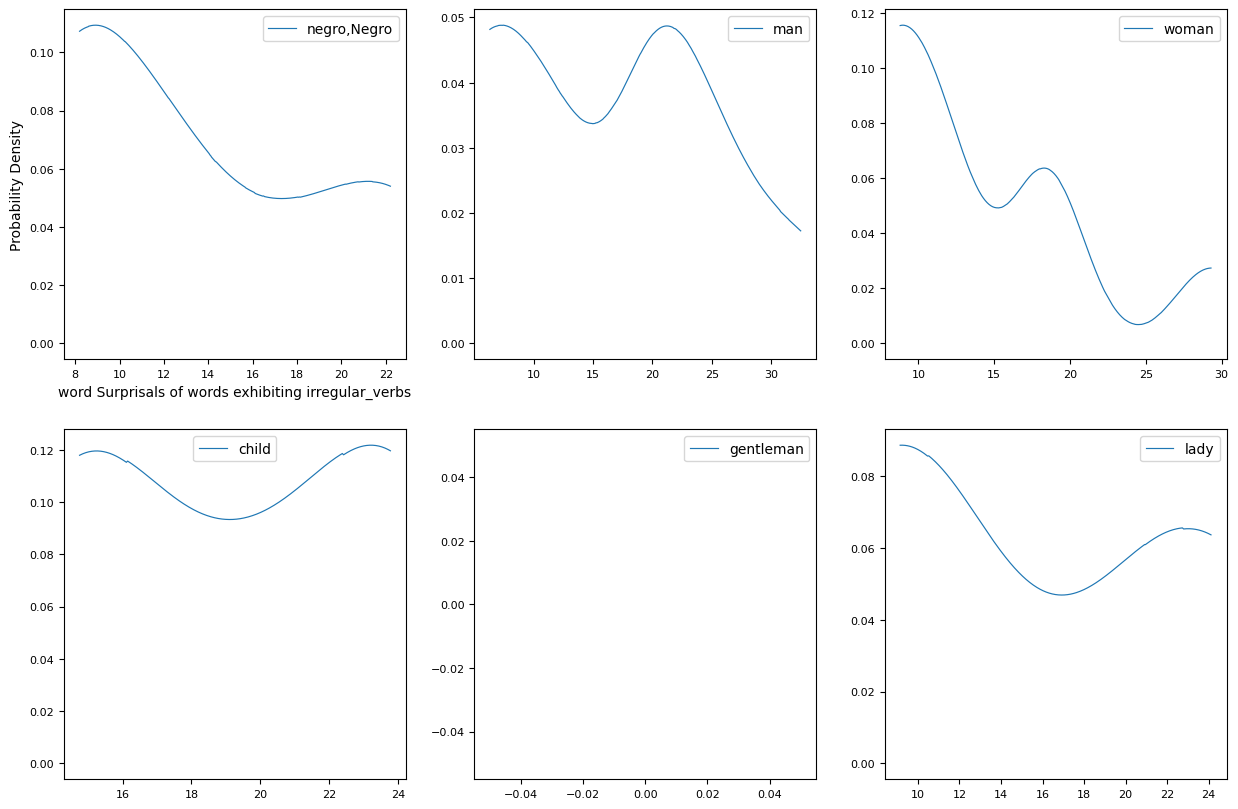

In [2162]:
variation = "irregular_verbs"
surprisals = {}  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}
instances = {}

# ------
# get the surprisals for all words demonstrative of the variation, for each speaker set
# ------

S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"]]
for speakers in S:
    print(speakers)
    surprisals[",".join(speakers)], instances[",".join(speakers)] = get_surprisals_for_variation(quotes, chains, variation, speakers)
# ------
# Get the MAS and newMAS for negro attributed quotation, where newMAS due to the absence of words showing the variation in question
# ------
speakers = ['negro', "Negro"]
i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))

# ------
# get contribution of variation to observed difference between reference speaker attributed quotations and negro attributed quotations
# ------
for speakers in S[1:]:

    # get mAS and newMAS removed of variation for speakers
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))

    # calculate the contribution of the variation to the observed mAS difference between n-word and reference speakers
    contribution = (MAS_negro - newMAS_negro) - (MAS - newMAS)
    relative_contribution = 100*contribution / (MAS_negro - MAS)
    print(speakers, contribution, relative_contribution)

# ------
# ;et's look at the plots of collection word (demonstrative of variation) surprisals
# ------
x,y = 2,3
fig, axs = plt.subplots(x, y, figsize=(15, 10))
for i, speakers in enumerate(S):

    row = i // y
    col = i - (row)*y
    az.plot_kde(np.array(surprisals[",".join(speakers)]), ax=axs[row, col], label=",".join(speakers), textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel(f"word Surprisals of words exhibiting {variation}")
        axs[row, col].set_ylabel("Probability Density")


let's take a random sample, and explore the effect on whole quotation probabilities from 'correction' not 'removal'

In [1159]:
sample = [(q[1:-1],q[1:-1])  for q in np.random.choice(quotes.loc[quotes.loc[:,'irregular_verbs_count'] == 1, "quote"], size=50)]
with open("sample_irregular_verbs.json", "w") as f:
    json.dump(sample, f)

## V->B

In [ ]:
# unix dict
with open("/usr/share/dict/words", "r") as f:
    en_words = [x.strip("\n") for x in f.readlines()]
en_words += [w.capitalize() for w in en_words]
en_words = set(en_words)

## Non--standard contractions (elision)

In [858]:
# unix dict
with open("/usr/share/dict/words", "r") as f:
    en_words = [x.strip("\n") for x in f.readlines()]
en_words += [w.capitalize() for w in en_words]
en_words = set(en_words)

In [1243]:
# what's in the CMU pronunciation that's absent from unix dict? 
import requests
lines = requests.get("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b").text.splitlines()

# add in CMU instances
CMU_words = set([line.split(" ")[0].lower() for line in lines] + [line.split(" ")[0].lower().capitalize() for line in lines])

In [1244]:
CMU_words - en_words

{'frankenfield',
 'burzynski',
 'Bondholders',
 'baum',
 'Anable',
 'Sponsorships',
 'Coutts',
 'sasayama',
 "Jafco's",
 'Samuels',
 'Minosos',
 'Dobler(1)',
 'Rebstock',
 'Basilia',
 'Danly',
 'maddox',
 'Luper',
 'vice-presidential',
 "rubik's",
 "roy's",
 "kevin's",
 'Conspiratorially(1)',
 'kieser',
 'meares',
 'youker',
 'Miti(1)',
 'zajdel',
 'dunleavy',
 'Redell',
 'Glomb',
 'smyth',
 'Isley',
 'Produc',
 'Wischmeyer',
 'Rehbein',
 'kershner',
 'girtman',
 'bolon',
 'vonarx',
 'aldis',
 'kasmer',
 'mcinnis',
 "seles'",
 'talese(1)',
 'Transcribers',
 'Dsouza',
 "consultants'",
 'Kestler',
 'celts(1)',
 'guimaraes',
 'Mirabelle',
 'Leilia',
 'Mims',
 'Guerry',
 'Statist',
 'notebaert',
 'Cincotta',
 'horsham',
 'Passes(1)',
 "hockney's",
 'pallo',
 'caribbean(1)',
 'Ursy',
 'Apel',
 'Adachi',
 'Brien',
 'melikian',
 'eisert',
 'Antifungal(1)',
 'lykens',
 'Carabajal',
 'petit',
 'earle',
 'Fruitopia',
 "Rivals'",
 'Eigen',
 'bolivians',
 'hedgecock',
 'kippur',
 'Lakefront',
 'Em

In [2244]:
# get the elision instances and their respective counts
def interesting_apos(word:str, en_words)->bool:

    # ignore standard contractions
    if (word.count("'") - word[-2:].count("'s") - -word[-3:].count("n't") - word[-2:].count("'d") - word[-3:].count("'ll") > 0 and len(word)>1):
        # consider possessives, e.g., witches'
        if word[-1] == "'" and word[:-1] in en_words:
            return False # it's just a possessive!
        return True  # it's a non--standard contraction!
    else:
        return False  # it's something standard!


quotes['elision'] = quotes['words'].progress_map(lambda words: [word for word in words if word not in en_words and interesting_apos(word, en_words)])
quotes['elision_count'] = quotes['elision'].progress_map(lambda words: len(words))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26502/26502 [00:00<00:00, 443483.82it/s]


In [886]:
quotes.loc[(quotes.loc[:, 'elision_count']>0) & (quotes.loc[:, 'speaker'].isin(['negro', "Negro"])), "elision"]


i
100                                             ['em]
257                                    ['pon, sayin']
331      [tol', 'bout, takin', sep'rate, goin', he'p]
474                                           ['spec]
487                                        ['em, 'em]
                             ...                     
25571                                [talkin', 'bout]
26425           [She'm, sinkin', she'm, goin', un'er]
26427                                         ['bout]
26459                                        ['Pears]
26486                                        [sayin']
Name: elision, Length: 238, dtype: object

relative rates

In [887]:
variation = "elision"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 3.662152416058979 457 12479
['man'] 1.240322252813245 2685 216476
['woman'] 1.531498976132707 890 58113
['gentleman'] 0.39338399642378186 88 22370
['lady'] 0.3197369022061846 210 65679
['child'] 0.8088235294117647 88 10880


contributions to difference in AvNLL

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3996/3996 [00:00<00:00, 5237.18it/s]


negro,Negro 16.51979612796078 15.986071244668915
['man'] 0.30950930519031594 27.837171517096433
['woman'] 0.2800882447110915 23.29706245939679
['child'] 0.4400522893684471 39.78026716326826
['gentleman'] 0.46804802628842346 30.42068753697454
['lady'] 0.48251878514553503 26.295229482791687


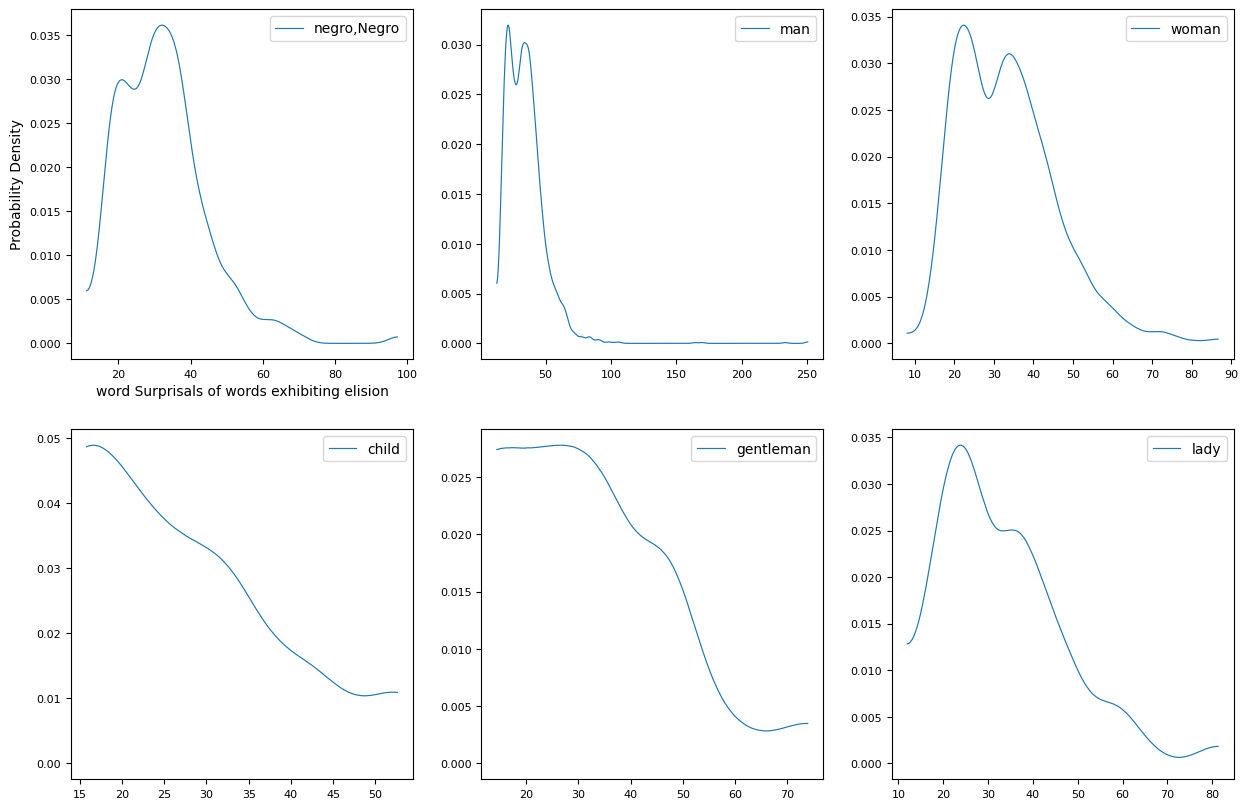

In [2163]:
variation = "elision"
surprisals = {}  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}
instances = {} 
# ------
# get the surprisals for all words demonstrative of the variation, for each speaker set
# ------

S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"]]
for speakers in S:
    surprisals[",".join(speakers)], instances[",".join(speakers)] = get_surprisals_for_variation(quotes, chains, variation, speakers)

# ------
# Get the MAS and newMAS for negro attributed quotation, where newMAS due to the absence of words showing the variation in question
# ------
speakers = ['negro', "Negro"]
i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))
print('negro,Negro', MAS_negro, newMAS_negro)

# ------
# get contribution of variation to observed difference between reference speaker attributed quotations and negro attributed quotations
# ------
for speakers in S[1:]:

    # get mAS and newMAS removed of variation for speakers
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))

    # calculate the contribution of the variation to the observed mAS difference between n-word and reference speakers
    # diff_when_removed = newMAS_negro - newMAS
    # contribution = (MAS_negro - MAS) - diff_when_removed
    contribution = (MAS_negro - newMAS_negro) - (MAS - newMAS)
    relative_contribution = 100*contribution / (MAS_negro - MAS)
    print(speakers, contribution, relative_contribution)

# ------
# ;et's look at the plots of collection word (demonstrative of variation) surprisals
# ------
x,y = 2,3
fig, axs = plt.subplots(x, y, figsize=(15, 10))
for i, speakers in enumerate(S):

    row = i // y
    col = i - (row)*y
    az.plot_kde(np.array(surprisals[",".join(speakers)]), ax=axs[row, col], label=",".join(speakers), textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel(f"word Surprisals of words exhibiting {variation}")
        axs[row, col].set_ylabel("Probability Density")


In [1208]:
instances

{'negro,Negro': ["'em",
  "'pon",
  "sayin'",
  "'bout",
  "sep'rate",
  "tol'",
  "goin'",
  "takin'",
  "he'p",
  "'spec",
  "'em",
  "'em",
  "comin'",
  "'im",
  "tyin'",
  "'em",
  "puttin'",
  "anyt'ing",
  "t'ink",
  "t'ink",
  "cap'n",
  "bes'",
  "bes'",
  "t'ink",
  "sho'",
  "fo'",
  "tryin'",
  "'tempt",
  "a-burnin'",
  "'Deed",
  "nex'",
  "'deed",
  "'deed",
  "t'other",
  "'Lethe",
  "nuttin'",
  "camp-meetin'",
  "I'se",
  "I'se",
  "I'se",
  "'fore",
  "nussin'",
  "you'se",
  "lookin'",
  "you'se",
  "'portant",
  "'em",
  "habin'",
  "ol'",
  "dey'se",
  "und'stan",
  "und'stan",
  "und'stan'",
  "waitin'",
  "'Sert",
  "'sert",
  "less'n",
  "des'",
  "'em",
  "'em",
  "'bout",
  "'ain't",
  "'im",
  "'Federate",
  "bain't",
  "You'se",
  "dar'",
  "mus'",
  "I'se",
  "'em",
  "'oman",
  "'taint",
  "jes'",
  "s'prised",
  "'possum",
  "I'se",
  "t'ing",
  "nex'",
  "Mahs'",
  "keepin'",
  "int'ruptin'",
  "comin'",
  "comin'",
  "'cept",
  "bes'",
  "f'ar",
  "b'l

## aux verbs (Be, Have, Do) conjugation normalised to third person singular

In [900]:
import spacy
nlp = spacy.load("en_core_web_sm")
from spacy import displacy

In [905]:
doc = nlp("I isn't tall")
{token.text: token.head.text for token in doc if is_reg_aux(token)}

{'I': 'is'}

In [906]:
def is_reg_aux(token):
    if token.text in ['I', 'you', 'You', 'we', 'We', 'they', 'They'] and token.head.text == 'is':
        return True
    else:
        return False

for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

     # get the quotation set, 'i' of interest
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    quotes.loc[i_of_interest, 'levellings_aux'] = quotes.loc[i_of_interest,'quote'].progress_map(lambda quote: [token.text + " " + token.head.text for token in nlp(quote[1:-1]) if is_reg_aux(token)])
    quotes.loc[i_of_interest,'levellings_aux_count'] = quotes.loc[i_of_interest,"levellings_aux"].progress_map(lambda x: len(x))



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 933/933 [00:00<00:00, 379010.71it/s]


In [904]:
for q in quotes.loc[(quotes.loc[:,'levellings_aux_count']>0) & (quotes.loc[:,'speaker'].isin(['Negro', 'negro'])), 'quote']:
    print(q)

"I'se sorry to part with ye, Kurnel, but I bless de Lord you is gwine. We'll meet again one of dese days, whar de Rebs won't trouble us, and whar we will be free foreber,"
"Why hello, Calvin, is that you?"
"scuse me fur int'ruptin', but I can't help it. Don' you go, an ax an ole man like me if I tinks dat ole miss went away cos you was comin' an' if it's my true b'lief dat she'll neber come back while you is h'yar. Don' ask me nuffin like dat, Mahs' Junius. Ise libed in dis place all my bawn days, an' I ain't neber done nuffin to you, Mahs' Junius, 'cept keepin' you from breakin' you neck when you was too little to know better. I neber 'jected to you marryin' any lady you like bes', an' 'tain't f'ar Mahs' Junius, now Ise ole an' gittin' on de careen, fur you to ax me wot I tinks about ole miss gwine away an' comin' back. I begs you, Mahs' Junius, don' ax me dat."
"You is one of us,"
"I was back. An honest man as I is, can't get on in this world. Necessity makes rascals of better men th

In [908]:
variation = "levellings_aux"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.10417501402355958 13.0 12479
['man'] 0.015706129085903287 34.0 216476
['woman'] 0.03613649269526612 21.0 58113
['gentleman'] 0.008940545373267769 2.0 22370
['lady'] 0.004567670031516923 3.0 65679
['child'] 0.03676470588235294 4.0 10880


contribution to difference in mean AvNLL

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3996/3996 [00:00<00:00, 6894.46it/s]
/home/ry/miniconda3/envs/70B/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


negro,Negro 16.51979612796078 16.51979612796078
['man'] 0.0 0.0
['woman'] 0.0 0.0
['child'] 0.0 0.0
['gentleman'] 0.0 0.0
['lady'] 0.0 0.0


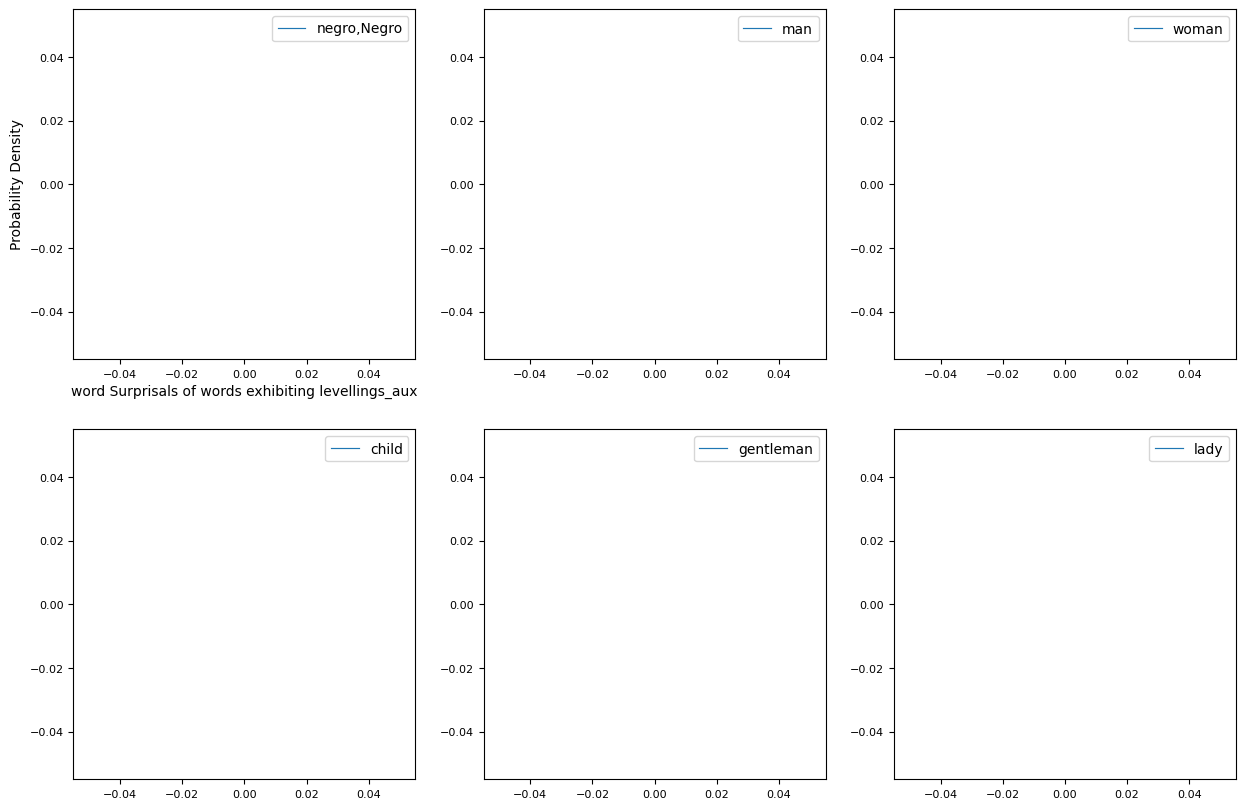

In [1214]:
variation = "levellings_aux"
surprisals = {}  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}
instances = {} 
# ------
# get the surprisals for all words demonstrative of the variation, for each speaker set
# ------

S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"]]
for speakers in S:
    surprisals[",".join(speakers)], instances[",".join(speakers)] = get_surprisals_for_variation(quotes, chains, variation, speakers)

# ------
# Get the MAS and newMAS for negro attributed quotation, where newMAS due to the absence of words showing the variation in question
# ------
speakers = ['negro', "Negro"]
i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))
print('negro,Negro', MAS_negro, newMAS_negro)

# ------
# get contribution of variation to observed difference between reference speaker attributed quotations and negro attributed quotations
# ------
for speakers in S[1:]:

    # get mAS and newMAS removed of variation for speakers
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))

    # calculate the contribution of the variation to the observed mAS difference between n-word and reference speakers
    contribution = (MAS_negro - newMAS_negro) - (MAS - newMAS)
    relative_contribution = 100*contribution / (MAS_negro - MAS)
    print(speakers, contribution, relative_contribution)

# ------
# ;et's look at the plots of collection word (demonstrative of variation) surprisals
# ------
x,y = 2,3
fig, axs = plt.subplots(x, y, figsize=(15, 10))
for i, speakers in enumerate(S):

    row = i // y
    col = i - (row)*y
    az.plot_kde(np.array(surprisals[",".join(speakers)]), ax=axs[row, col], label=",".join(speakers), textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel(f"word Surprisals of words exhibiting {variation}")
        axs[row, col].set_ylabel("Probability Density")



## Double Modals

e.g., I might could go with you

Consider most common english modals: can, could, may, might, will, would, shall, should, must, ought to, 
Which of these have variation in 1st/2nd/3rd person conjugations?: None

In [1215]:
modals = ['can', 'could', 'may', 'might', 'would', 'shall', 'should', 'must', 'ought to', "can't", "couldn't", "mightn't", "won't", "wouldn't", "shalln't", "shouldn't", "mustn't", "oughtn't to"]
    

detection

In [1216]:
quotes['double_modals'] = quotes['quote'].progress_map(lambda quote: [" ".join(double) for double in permutations(modals, 2) if " " +  " ".join(double) + " " in quote])
quotes['double_modals_count'] = quotes['double_modals'].progress_map(lambda x: len(x))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26502/26502 [00:00<00:00, 627359.54it/s]


In [1217]:
for x in list(quotes.loc[quotes.loc[:,'double_modals_count'] > 0, 'quote']):
    print(x)

Very few instances observed, none in our negro or normative cases, and sometimes, it's a question of missing comma or word: "The best I can shall be done,"

rates of occurrence

In [1218]:
variation = "double_modals"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.0 0 12479
['man'] 0.0 0 216476
['woman'] 0.0 0 58113
['gentleman'] 0.0 0 22370
['lady'] 0.0 0 65679
['child'] 0.0 0 10880


## Double Negation

E.g., "I ain't never"

In [1219]:
p = re.compile(r"\s+\w+(?:n't|aint|haint)\s+(?!said no|say no|saying no)(?:\w+\s+){,2}(?:(?:nuff|noff|noth)in[kg']*|ne[vb]+er|nobody|no)")

# test 1
s = "No, I hain\'t said nuffin,"

# find matches ...
matches = re.findall(p, s)
display(matches)

# find the indices of the matches
for m in matches:
    
    quote_words = get_words(s)    
    match_words = get_words(m)

    for lb, ub in gen_indices(quote_words, match_words):
        print(lb,ub,quote_words[lb:ub])

[" hain't said nuffin"]

3 6 ["hain't", 'said', 'nuffin']


In [1220]:
# test 2
s = ['How', 'kin', 'I', 'go', '?', 'I', "ain't", 'got', 'no', 'money', ',', 'and', 'I', "ain't", 'got', 'the', "stren'th", 'to', 'walk', '.', "I'm", "jes'", 'a', 'pore', 'ole', 'man', 'what', "don't", 'mean', 'no', 'harm', 'to', 'nobody', '.', 'Take', 'me', 'along', 'with', 'you-all', '!', "I'm", 'afeared', 'the', "Riders'll", 'git', 'me', "ag'in", '.', 'I', 'come', 'back', 'to', 'see', 'my', 'darter', ',', 'the', 'onliest', 'chile', 'I', 'got', 'in', 'the', "worl'", '.', 'I', "ain't", 'got', 'no', 'other', 'place', 'to', 'go', 'at', '.', 'The', 'Madam', "won't", 'let', 'a', 'pore', 'ole', 'man', 'suffer', '.', 'I', 'wants', 'to', 'see', 'my', 'darter', '.']
o = ["ain't", 'got', 'no']

for lb,ub in gen_indices(s, o):
    print(lb,ub,s[lb:ub])

6 9 ["ain't", 'got', 'no']
66 69 ["ain't", 'got', 'no']


In [1221]:

quotes['double_negatives'] = quotes['quote'].progress_map(lambda quote: re.findall(p, quote))
quotes['double_negatives_count'] = quotes['double_negatives'].progress_map(lambda x: len(x))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26502/26502 [00:00<00:00, 1068883.25it/s]


In [1222]:
list(zip(quotes.loc[(quotes.loc[:,'double_negatives_count']>0) & (quotes.loc[:,'speaker'].isin(["negro", "Negro"])), 'double_negatives'], quotes.loc[(quotes.loc[:,'double_negatives_count']>0) & (quotes.loc[:,'speaker'].isin(["negro", "Negro"])), 'quote']))


[([" don't know nuffin"],
  '"Carl\'s forgot his English, and don\'t know nuffin what she wants! he, he, he! Or if she makes him und\'stan\' one ting, den he talks Dutch, and _she_ don\'t und\'stan.\' And so dey\'se habin\' it, fust one, den tudder, while Miss Jinny she hears \'em and comes fur to let us know. But how de ol\' critter eber found you out, dat am one ob de mysteries!"'),
 ([" ain't neber done nuffin"],
  '"scuse me fur int\'ruptin\', but I can\'t help it. Don\' you go, an ax an ole man like me if I tinks dat ole miss went away cos you was comin\' an\' if it\'s my true b\'lief dat she\'ll neber come back while you is h\'yar. Don\' ask me nuffin like dat, Mahs\' Junius. Ise libed in dis place all my bawn days, an\' I ain\'t neber done nuffin to you, Mahs\' Junius, \'cept keepin\' you from breakin\' you neck when you was too little to know better. I neber \'jected to you marryin\' any lady you like bes\', an\' \'tain\'t f\'ar Mahs\' Junius, now Ise ole an\' gittin\' on de ca

rate of variation observed

In [1223]:
variation = "double_negatives"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.11218847664075647 14 12479
['man'] 0.05497145180066151 119 216476
['woman'] 0.08087691222273846 47 58113
['gentleman'] 0.004470272686633884 1 22370
['lady'] 0.012180453417378462 8 65679
['child'] 0.027573529411764705 3 10880


Get contribution to mean AvNLL

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3996/3996 [00:00<00:00, 5926.27it/s]
/home/ry/miniconda3/envs/70B/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


negro,Negro 16.51979612796078 16.51979612796078
['man'] 0.0 0.0
['woman'] 0.0 0.0
['child'] 0.0 0.0
['gentleman'] 0.0 0.0
['lady'] 0.0 0.0


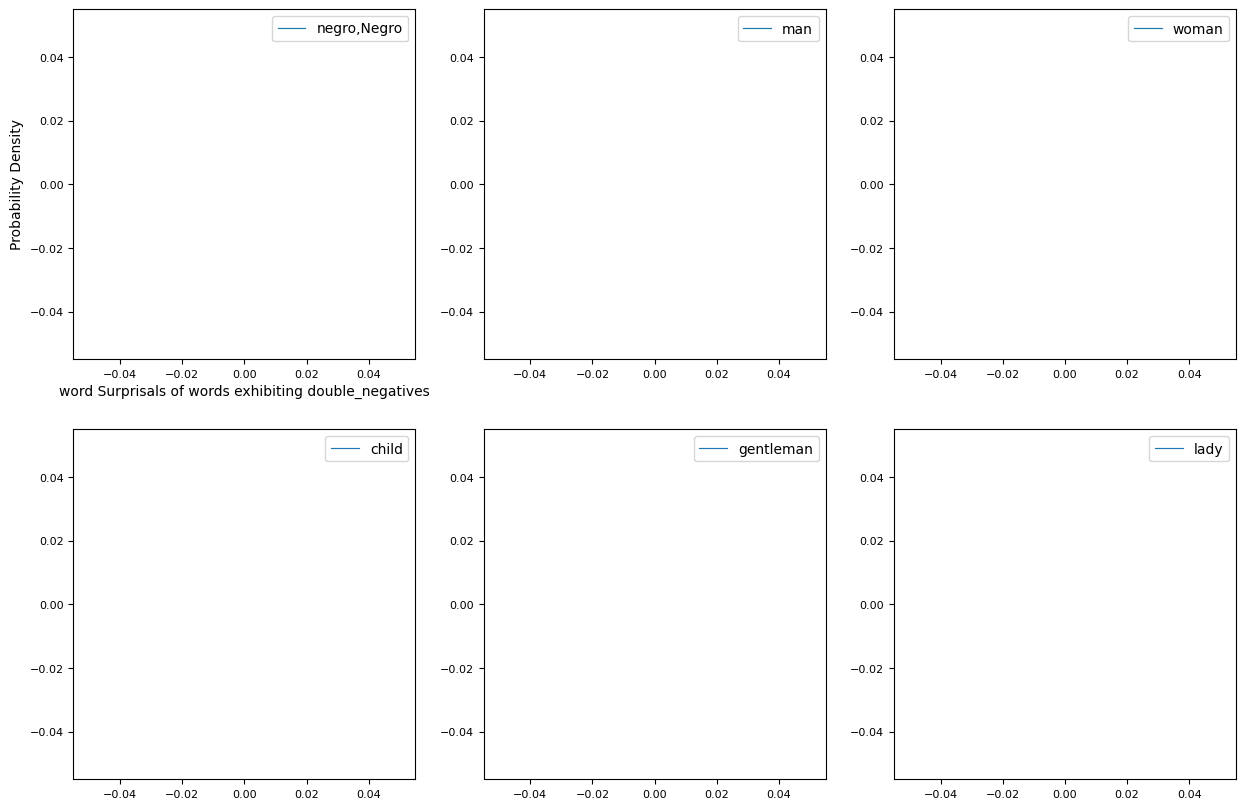

In [1224]:
variation = "double_negatives"
surprisals = {}  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}
instances = {} 
# ------
# get the surprisals for all words demonstrative of the variation, for each speaker set
# ------

S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"]]
for speakers in S:
    surprisals[",".join(speakers)], instances[",".join(speakers)] = get_surprisals_for_variation(quotes, chains, variation, speakers)

# ------
# Get the MAS and newMAS for negro attributed quotation, where newMAS due to the absence of words showing the variation in question
# ------
speakers = ['negro', "Negro"]
i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))
print('negro,Negro', MAS_negro, newMAS_negro)

# ------
# get contribution of variation to observed difference between reference speaker attributed quotations and negro attributed quotations
# ------
for speakers in S[1:]:

    # get mAS and newMAS removed of variation for speakers
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))

    # calculate the contribution of the variation to the observed mAS difference between n-word and reference speakers
    contribution = (MAS_negro - newMAS_negro) - (MAS - newMAS)
    relative_contribution = 100*contribution / (MAS_negro - MAS)
    print(speakers, contribution, relative_contribution)

# ------
# ;et's look at the plots of collection word (demonstrative of variation) surprisals
# ------
x,y = 2,3
fig, axs = plt.subplots(x, y, figsize=(15, 10))
for i, speakers in enumerate(S):

    row = i // y
    col = i - (row)*y
    az.plot_kde(np.array(surprisals[",".join(speakers)]), ax=axs[row, col], label=",".join(speakers), textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel(f"word Surprisals of words exhibiting {variation}")
        axs[row, col].set_ylabel("Probability Density")



## done VERB

they done ate all of their food


In [1225]:
import spacy

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [1226]:
nlp = spacy.load("en_core_web_sm")

In [1227]:
re.findall("done said", "he done said it")

['done said']

detection

In [1228]:
for token in nlp("what's happening?"):
    print(token.text)

what
's
happening
?


In [1229]:
quotes.loc[quotes.loc[:, 'quote']==False, 'i']

Series([], Name: i, dtype: int64)

In [1231]:
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:
    
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    quotes.loc[i_of_interest, 'spacy_tokens'] = quotes.loc[i_of_interest, 'quote'].progress_map(lambda quote: [(token.text, token.pos_) for token in nlp(quote[1:-1])])
    quotes.loc[i_of_interest, 'done_VERB'] = quotes.loc[i_of_interest, "spacy_tokens"].progress_map(lambda tuples: [c[0] for p, c in zip(tuples[:-1], tuples[1:]) if p[0]=='done' and c[1]=="VERB"])
    # we only record VERB ... this is where the heighted effect
    
    quotes.loc[i_of_interest, 'done_VERB_count'] = quotes.loc[i_of_interest, 'done_VERB'].progress_map(lambda x: len(x))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 933/933 [00:00<00:00, 342190.07it/s]


In [1015]:
for q in quotes.loc[quotes.loc[:,'done_VERB_count'] > 0, 'quote']:
    print(q)

"But ain't I done won it?"
"he al'ays yells like that when his Ma's done scrubbed him."
"But I have hearn the bride's name; and a rum un it is, too! Lady, Lady Hoist? no! Hurl? no! Hurt? yes, that is it! Lady Hurt-me-so, that's the name of the lady he's done married!"
"Now, sure as the world, honey, you done heard somefin 'bout de poor young marser? Is he come to an accident, honey?"
"Yes, Dinah, 'oman, here day is; little foot-prints in de snow a-goin' away from de house an' almost covered up now! She done gone! Now don't dat beat eberything? Now she'll be froze to death, 'less I goes out in de storm to look for her; an' maybe she'll be froze anyway; for dere's no sartainty 'bout my findin' of her. Now aint dat a trial for any colored gentleman's narves! Well den, here goes! Wait for me here, ole 'omen, till I come back, and if I nebber comes, all I leabes is yourn, you know,"
"He's done gone out in de new-ground terbacker, long wid de han's,"
"Dunno whar ole miss is, but I reckon she

In [1233]:
variation = "done_VERB"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.040067313085984456 5.0 12479
['man'] 0.012934459247214472 28.0 216476
['woman'] 0.005162356099323731 3.0 58113
['gentleman'] 0.004470272686633884 1.0 22370
['lady'] 0.0 0.0 65679
['child'] 0.027573529411764705 3.0 10880


['negro', 'Negro']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 816/816 [00:00<00:00, 3470.07it/s]


['man']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15176/15176 [00:02<00:00, 6595.76it/s]


['woman']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4100/4100 [00:00<00:00, 6399.82it/s]


['child']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 933/933 [00:00<00:00, 6287.64it/s]


['gentleman']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1478/1478 [00:00<00:00, 6064.73it/s]


['lady']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3996/3996 [00:00<00:00, 6535.63it/s]
/home/ry/miniconda3/envs/70B/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


['man'] -0.0025122586437849037 -0.22595176813616707
['woman'] -0.0032430780856866903 -0.269751387820211
['child'] -0.0027123332229983532 -0.24519208933450784
['gentleman'] -0.0032299892983989054 -0.20993250622921175
['lady'] -0.0036609317218498916 -0.19950526841735208


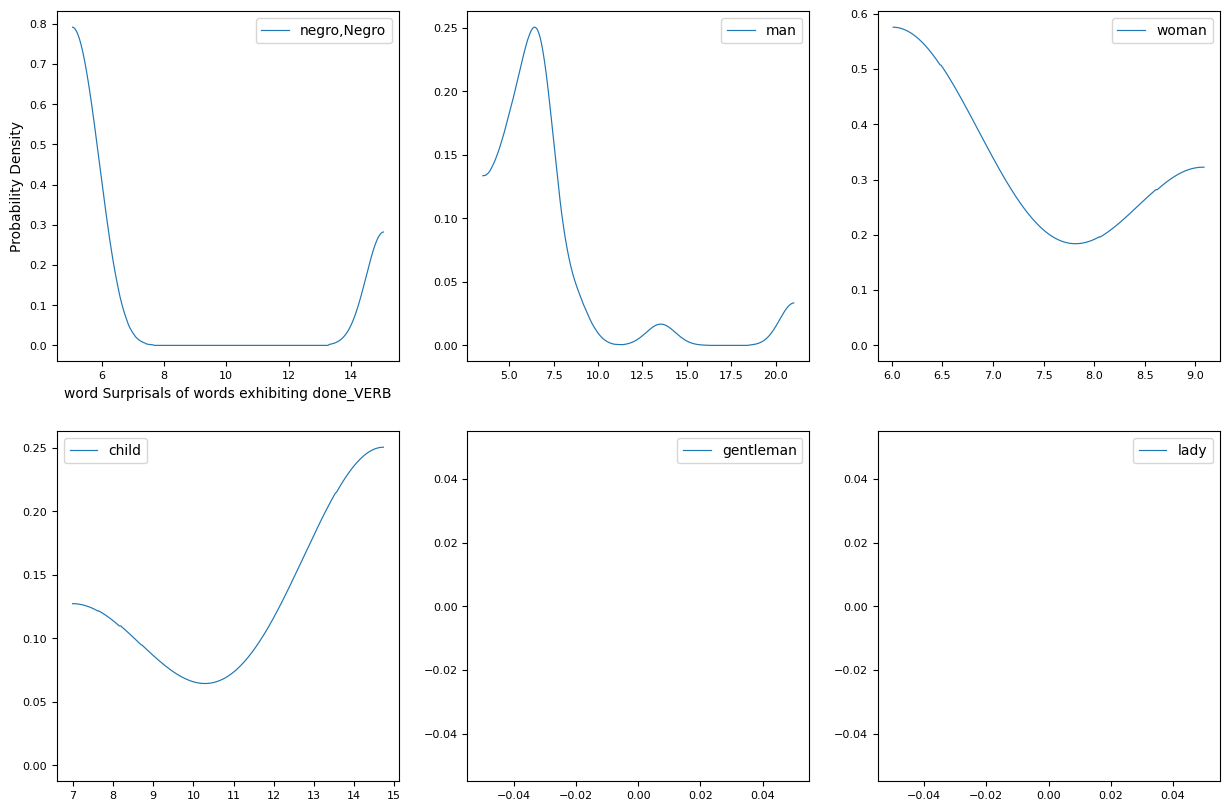

In [1234]:
variation = "done_VERB"
surprisals = {}  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}
instances = {}

# ------
# get the surprisals for all words demonstrative of the variation, for each speaker set
# ------

S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"]]
for speakers in S:
    print(speakers)
    surprisals[",".join(speakers)], instances[",".join(speakers)] = get_surprisals_for_variation(quotes, chains, variation, speakers)
# ------
# Get the MAS and newMAS for negro attributed quotation, where newMAS due to the absence of words showing the variation in question
# ------
speakers = ['negro', "Negro"]
i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))

# ------
# get contribution of variation to observed difference between reference speaker attributed quotations and negro attributed quotations
# ------
for speakers in S[1:]:

    # get mAS and newMAS removed of variation for speakers
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))

    # calculate the contribution of the variation to the observed mAS difference between n-word and reference speakers
    contribution = (MAS_negro - newMAS_negro) - (MAS - newMAS)
    relative_contribution = 100*contribution / (MAS_negro - MAS)
    print(speakers, contribution, relative_contribution)

# ------
# ;et's look at the plots of collection word (demonstrative of variation) surprisals
# ------
x,y = 2,3
fig, axs = plt.subplots(x, y, figsize=(15, 10))
for i, speakers in enumerate(S):

    row = i // y
    col = i - (row)*y
    az.plot_kde(np.array(surprisals[",".join(speakers)]), ax=axs[row, col], label=",".join(speakers), textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel(f"word Surprisals of words exhibiting {variation}")
        axs[row, col].set_ylabel("Probability Density")



## voiceless dental fricative (TH) as 'f'

In [1254]:
# Load the CMU pronunciation dictionary
import requests
lines = requests.get("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b").text.splitlines()

# ignore eveything up the 'A  AH0'
lines = lines[lines.index('A  AH0'):]

In [1255]:
# load unix dict
with open("/usr/share/dict/words", "r") as f:
    en_words = [x.strip("\n") for x in f.readlines()]
en_words += [w.capitalize() for w in en_words]

# add in instances with "ing" replaced with "in'"
en_words += [word[:-3] + "in'" for word in en_words if word[-3:]=="ing"]

en_words = set(en_words)

In [1279]:
# get all words with TH
TH = [line for line in lines if " TH" in line]
TH

['AALSETH  AA1 L S EH0 TH',
 'ABENDROTH  AE1 B IH0 N D R AO0 TH',
 'ABERNATHY  AE1 B ER0 N AE2 TH IY0',
 'ABERNETHY  AE1 B ER0 N EH2 TH IY0',
 'ABSINTHE  AE1 B S IH0 N TH',
 'ACCUHEALTH  AE1 K Y UW0 HH EH2 L TH',
 'ACERO(2)  AH0 TH EH1 R OW0',
 'AEROSMITH  EH1 R OW0 S M IH2 TH',
 "AEROSMITH'S  EH1 R OW0 S M IH2 TH S",
 'AESTHENOPIA  AE0 S TH AH0 N AO1 P Y AH0',
 'AESTHETE  EH1 S TH IY0 T',
 "AESTHETE'S  EH1 S TH IY0 T S",
 'AESTHETES  EH1 S TH IY0 T S',
 'AESTHETIC  EH0 S TH EH1 T IH0 K',
 'AESTHETICALLY  EH0 S TH EH1 T IH0 K L IY0',
 'AESTHETICS  EH0 S TH EH1 T IH0 K S',
 'AFORETHOUGHT  AH0 F AO1 R TH AA2 T',
 'AFTERMATH  AE1 F T ER0 M AE2 TH',
 'AFTERMATHS  AE1 F T ER0 M AE2 TH S',
 'AFTERTHOUGHT  AE1 F T ER0 TH AA2 T',
 'AFTERTHOUGHT(1)  AE1 F T ER0 TH AO2 T',
 'AFTERTHOUGHTS  AE1 F T ER0 TH AA2 T S',
 'AFTERTHOUGHTS(1)  AE1 F T ER0 TH AO2 T S',
 'AGATHA  AE1 G AH0 TH AH0',
 'AINSWORTH  EY1 N S W ER0 TH',
 "AINSWORTH'S  EY1 N Z W ER0 TH S",
 'AITHNE  EY1 TH N',
 'ALBERTHAL  AE1 L B 

In [1297]:
# Expand TH to include variants of words where ING is replaced with IN'
TH_ = []
for line in TH:

    # get word and rest
    splits = line.split(" ")
    word = splits[0]
    word = word.split("(")[0]
    rest = " ".join(splits[1:])

    # create word variant where "ING" == "IN'"
    if word[-3:] == "ING":
        word_ = word[:-1] + "'"
        TH_.append(word + " " + rest)

TH = TH + TH_

In [1247]:
# # expand en_words with TH variants
# CMU_words = set([line.split(" ")[0].lower() for line in lines] + [line.split(" ")[0].lower().capitalize() for line in lines])
# CMU_words - en_words

In [1302]:
# build a word list variants, replacing TH with f and/or ff
f = []
for line in TH:

    splits = line.split(" ")
    word = splits[0]
    word = word.split("(")[0]  # cases where word followed by e.g., (1), signalling a variant
    ARPAbet_rep = line.split(" ")[1:]

    # get indices of 'th' positions in word (it's just words are uppercase in CMU)
    th_indices = find_all_indices(word, 'TH')

    # order of occurrence of DH or TH sounds (i.e., how 'th' sounds) in ARPAbet representation
    th_sounds = [x for x in ARPAbet_rep if x == "DH" or x =='TH']


    # convert th letters corresponding to DH sound, as ...
    for i, th_sound in zip(th_indices, th_sounds):

        if th_sound == 'TH':
            var1 = word[:i] + 'F' + word[i+len('TH'):]  # with -> wif
            f.append(var1)
            var2 = word[:i] + 'FF' + word[i+len('TH'):]  #with -> wiff
            f.append(var2)

        # #trivial check
        # if word=="WITH":
        #     print(f[-2:])

# lowercase
f = [x.lower() for x in set(f)]

# get uppercase variants
f += [x.capitalize() for x in f]

# remove instances present in en_words
print(len(f))
f = set([x for x in f if x not in en_words])
print(len(f))
            


11052
10925


In [1304]:
"wif" in f

True

In [1305]:
quotes['th-f'] = quotes['words'].progress_map(lambda words: f.intersection(words))
quotes['th-f_count'] = quotes['th-f'].progress_map(lambda x: len(x))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26502/26502 [00:00<00:00, 728165.95it/s]


In [1306]:
for q in quotes.loc[quotes.loc[:,'th-f_count']>0,'th-f'][:50]:
    print(q)

{'lef'}
{'lef'}
{'Fong'}
{'mouf', 'lef'}
{'Hildreff'}
{'frew'}
{'mouf', 'paf'}
{'Souf', 'lef'}
{'haf'}
{'frew'}
{'haf'}
{'Norf', 'truf'}
{'Norf'}
{"somefin'", "Somefin'"}
{'wif'}
{"Noffin'"}
{'luff'}
{'toof'}
{'Neff'}
{'wif'}
{'noffin'}
{'boff'}
{'cloff'}
{'haf'}
{'sef'}
{'mouf', 'laf', 'bof', 'fru', 'moufful'}
{'fousand'}
{'nofin', 'truf'}
{'lef'}
{'Luff'}
{'mouf', 'paf'}
{'haf'}


In [1309]:
variation = "th-f"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.10417501402355958 13 12479
['man'] 0.006467229623607236 14 216476
['woman'] 0.024090995130177414 14 58113
['gentleman'] 0.008940545373267769 2 22370
['lady'] 0.0 0 65679
['child'] 0.0 0 10880


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3996/3996 [00:00<00:00, 5502.45it/s]
/home/ry/miniconda3/envs/70B/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


negro,Negro 16.51979612796078 16.504555160163793
['man'] 0.014548697099366237 1.30850533316377
['woman'] 0.01347817413565977 1.1210819111704675
['child'] 0.015240967796987803 1.3777675640798872
['gentleman'] 0.014469297815388416 0.9404291076961353
['lady'] 0.015240967796987803 0.8305681728862755


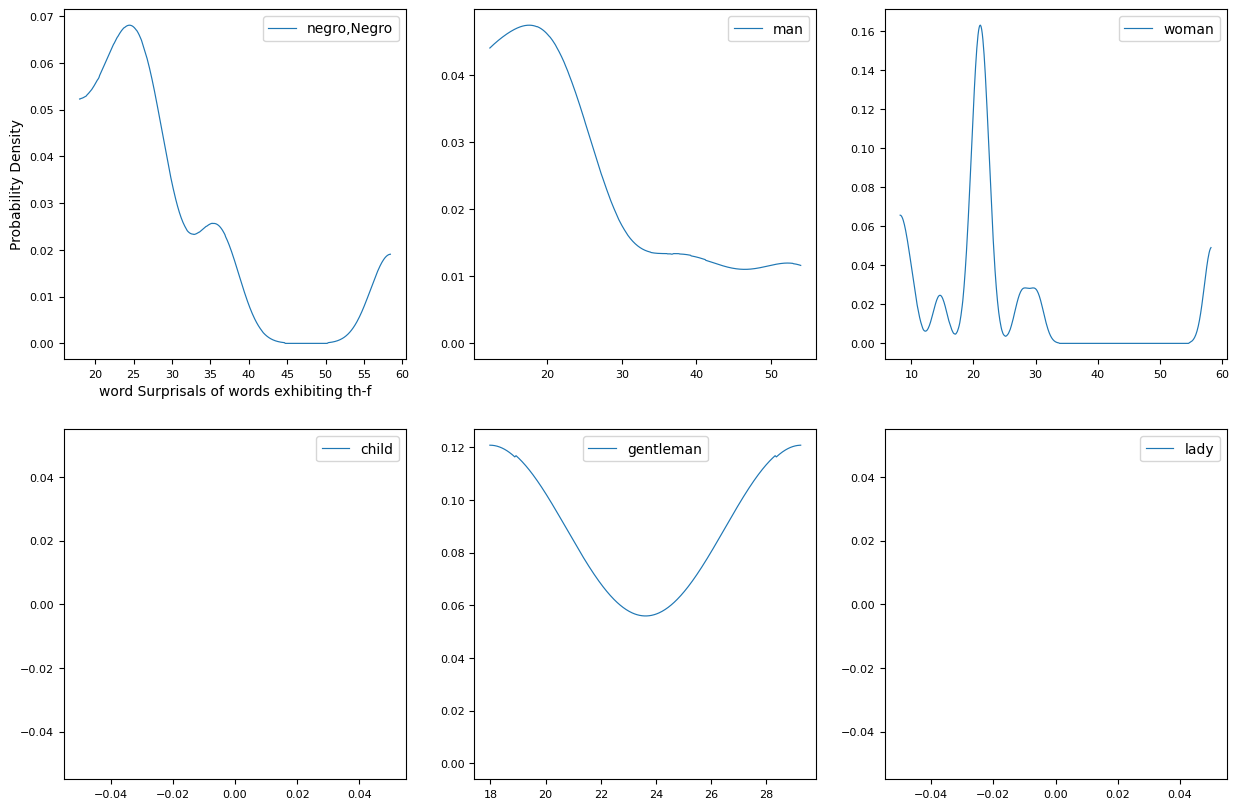

In [1311]:
variation = "th-f"
surprisals = {}  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}
instances = {} 
# ------
# get the surprisals for all words demonstrative of the variation, for each speaker set
# ------

S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"]]
for speakers in S:
    surprisals[",".join(speakers)], instances[",".join(speakers)] = get_surprisals_for_variation(quotes, chains, variation, speakers)

# ------
# Get the MAS and newMAS for negro attributed quotation, where newMAS due to the absence of words showing the variation in question
# ------
speakers = ['negro', "Negro"]
i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))
print('negro,Negro', MAS_negro, newMAS_negro)

# ------
# get contribution of variation to observed difference between reference speaker attributed quotations and negro attributed quotations
# ------
for speakers in S[1:]:

    # get mAS and newMAS removed of variation for speakers
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))

    # calculate the contribution of the variation to the observed mAS difference between n-word and reference speakers
    contribution = (MAS_negro - newMAS_negro) - (MAS - newMAS)
    relative_contribution = 100*contribution / (MAS_negro - MAS)
    print(speakers, contribution, relative_contribution)

# ------
# ;et's look at the plots of collection word (demonstrative of variation) surprisals
# ------
x,y = 2,3
fig, axs = plt.subplots(x, y, figsize=(15, 10))
for i, speakers in enumerate(S):

    row = i // y
    col = i - (row)*y
    az.plot_kde(np.array(surprisals[",".join(speakers)]), ax=axs[row, col], label=",".join(speakers), textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel(f"word Surprisals of words exhibiting {variation}")
        axs[row, col].set_ylabel("Probability Density")

## voiced dental fricative (DH) as 'd' 

E.g., this --> dis
    

In [1313]:
# Load the CMU pronunciation dictionary
import requests
lines = requests.get("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b").text.splitlines()

# ignore eveything up the 'A  AH0'
lines = lines[lines.index('A  AH0'):]

In [1039]:
# load unix dict
with open("/usr/share/dict/words", "r") as f:
    en_words = [x.strip("\n") for x in f.readlines()]
en_words += [w.capitalize() for w in en_words]

# add in instances with "ing" replaced with "in'"
en_words += [word[:-3] + "in'" for word in en_words if word[-3:]=="ing"]

en_words = set(en_words)

In [1315]:
# get all words with DH
DH = [line for line in lines if " DH" in line]
DH[:10]

['ACANTHA  AA0 K AA1 N DH AH0',
 'AIRWORTHINESS  EH1 R W ER2 DH IY0 N AH0 S',
 'AIRWORTHY  EH1 R W ER2 DH IY0',
 'ALGORITHM  AE1 L G ER0 IH2 DH AH0 M',
 'ALGORITHMS  AE1 L G ER0 IH2 DH AH0 M Z',
 'ALTHOUGH  AO2 L DH OW1',
 'ALTOGETHER  AO2 L T AH0 G EH1 DH ER0',
 'ANOTHER  AH0 N AH1 DH ER0',
 "ANOTHER'S  AH0 N AH1 DH ER0 Z",
 'ANTHES  AE1 N DH AH0 Z']

In [1316]:
# Expand DH to include variants of words where ING is replaced with IN'
DH_ = []
for line in DH:

    # get word and rest
    splits = line.split(" ")
    word = splits[0]
    word = word.split("(")[0]
    rest = " ".join(splits[1:])

    # create word variant where "ING" == "IN'"
    if word[-3:] == "ING":
        word_ = word[:-1] + "'"
        DH_.append(word + " " + rest)

DH = DH + DH_

In [1317]:
# # expand en_words with DH variants
# en_words += [line.split(" ")[0].lower() for line in lines] + [line.split(" ")[0].lower().capitalize() for line in lines]
# en_words = set(en_words)

In [1326]:
find_all_indices('hello', 'el')

[1]

In [2155]:
# build a word list variants, replacing th letters corresponding to DH sound, with ...
d = []

# DH -> d and dd
for line in DH:

    splits = line.split(" ")
    word = splits[0]
    word = word.split("(")[0]
    ARPAbet_rep = splits[1:]

    # get indices of 'th' positions in word
    th_indices = find_all_indices(word, 'TH')

    # order of occurrence of DH or TH sounds in ARPAbet representation
    th_sounds = [x for x in ARPAbet_rep if x == "DH" or x =='TH']

    # convert th letters corresponding to DH sound, as ...
    for i, th_sound in zip(th_indices, th_sounds):
        if th_sound == 'DH':
            var1 = word[:i] + 'D' + word[i+len('TH'):]  #this -> dis
            d.append(var1)
            var2 = word[:i] + 'DD' + word[i+len('TH'):]  #with -> widd
            d.append(var2)

# add variant, replacing OTH letters corresponding to "AH1 DH" sound, with "UDD"
for line in DH:

    splits = line.split(" ")
    word = line.split(" ")[0]
    word = splits[0]
    ARPAbet_rep = splits[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AH1', 'DH'])))>0:

        # get indices of 'oth' positions in word
        oth_indices = find_all_indices(word, 'OTH')
        th_indices = find_all_indices(word, 'TH')
        oth_and_th_indices = sorted(oth_indices + th_indices)
    
        # order of occurrence of DH or TH or AH1 DH sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AH1":
                th_sounds.append('AH1 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert oth letters corresponding to AH1 DH sound, as ...
        for i, th_sound in zip(oth_and_th_indices, th_sounds):
            if th_sound == 'AH1 DH':
                var1 = word[:i] + 'UDD' + word[i+len('OTH'):]  #this -> dis
                d.append(var1)

# add variant, replacing OTH letters corresponding to "AA1 DH" sound, with "ARD"
for line in DH:

    splits = line.split(" ")
    word = line.split(" ")[0]
    word = splits[0]
    ARPAbet_rep = splits[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AA1', 'DH'])))>0:

        # get indices of 'oth' positions in word
        ath_indices = find_all_indices(word, 'OTH')
        th_indices = find_all_indices(word, 'TH')
        ath_and_th_indices = sorted(oth_indices + th_indices)
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AA1":
                th_sounds.append('AA1 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert ath letters corresponding to AA1 DH sound, as ...
        for i, th_sound in zip(ath_and_th_indices, th_sounds):
            if th_sound == 'AA1 DH':
                var1 = word[:i] + 'ARD' + word[i+len('ATH'):]  #father -> farder
                print(word, var1)
                d.append(var1)

# add variant, replacing OTH letters corresponding to "AA2 DH" sound, with "ARD"
for line in DH:

    splits = line.split(" ")
    word = line.split(" ")[0]
    word = splits[0]
    ARPAbet_rep = splits[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AA2', 'DH'])))>0:

        # get indices of 'oth' positions in word
        ath_indices = find_all_indices(word, 'OTH')
        th_indices = find_all_indices(word, 'TH')
        ath_and_th_indices = sorted(oth_indices + th_indices)

        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AA2":
                th_sounds.append('AA2 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert ath letters corresponding to AA1 DH sound, as ...
        var1 = word
        for i, th_sound in zip(ath_and_th_indices, th_sounds):
            if th_sound == 'AA2 DH':
                var1 = var1[:i] + 'ARD' + var1[i+len('ATH'):]  #father -> farder
                d.append(var1)

# # add variants where v --> b or bb
# d += [x.replace('v', 'b') for x in d if 'v' in x]
# d += [x.replace('v', 'bb') for x in d if 'v' in x]

# lowercase
d = [x.lower() for x in d]       
            
# get uppercase variants
d += [x.capitalize() for x in d]

# remove instances present in en_words
print(len(d))
d = set([x for x in d if x not in en_words])
print(len(d))

BOTHER BOARDR
BOTHERED BOARDRED
BOTHERING BOARDRING
BOTHERS BOARDRS
BOTHERSOME BOARDRSOME
FATHER FAARDR
FATHER'S FAARDR'S
FATHER-IN-LAW FAARDR-IN-LAW
FATHERED FAARDRED
FATHERHOOD FAARDRHOOD
FATHERING FAARDRING
FATHERLAND FAARDRLAND
FATHERLESS FAARDRLESS
FATHERLY FAARDRLY
FATHERS FAARDRS
MATHIA MAARDA
PROTHERO PROARDRO
STROTHER STROARDR
SWATHE SWAARD
SWATHED SWAARDD
BOTHERING BOARDRING
FATHERING FAARDRING
2716
2330


In [1333]:
d

{'Anudder',
 "Anudder's",
 'Boardr',
 'Boardred',
 'Boardring',
 'Boardrs',
 'Boardrsome',
 'Brudder',
 "Brudder's",
 'Brudder-in-law',
 'Brudderhood',
 'Brudderly',
 'Brudders',
 "Brudders'",
 "Brudders's",
 'Brudders-in-law',
 'Brudderson',
 'Brudderton',
 'Carruuddrs',
 'Caruuddrs',
 'Crudders',
 'Cuddern',
 'Druuddrs',
 'Faardr',
 "Faardr's",
 'Faardr-in-law',
 'Faardred',
 'Faardrhood',
 'Faardring',
 'Faardrland',
 'Faardrless',
 'Faardrly',
 'Faardrs',
 'Forefaardr',
 'Forefaardrs',
 'Fuddergill',
 'Fudderingham',
 'Fuuddr',
 'Godfaardr',
 "Godfaardr's",
 'Godfaardrs',
 'Grandfaardr',
 "Grandfaardr's",
 "Grandfaardr's(1)",
 'Grandfaardr(1)',
 'Grandfaardred',
 'Grandfaardred(1)',
 'Grandfaardring',
 'Grandfaardring(1)',
 'Grandfaardrly',
 'Grandfaardrly(1)',
 'Grandfaardrs',
 'Grandfaardrs(1)',
 'Great-grandfaardr',
 'Maarda',
 'Mudder',
 "Mudder's",
 'Mudder-in-law',
 'Muddercare',
 'Mudderfucker',
 "Mudderfucker's",
 'Mudderfuckers',
 'Mudderfucking',
 'Mudderhood',
 'Mudderin

#### n-word,lit vs normative,lit

In [1042]:
quotes['dh-d'] = quotes['words'].progress_map(lambda words: d.intersection(words))
quotes['dh-d_count'] = quotes['dh-d'].progress_map(lambda x: len(x))

100%|█████████████████████████████████████████████████| 2379076/2379076 [00:01<00:00, 2189669.24it/s]


In [1043]:
quotes.loc[quotes.loc[:,'dh-d_count']>0,'dh-d']

6606             {Dat's}
7536             {dat's}
8076           {anodder}
16881              {dem}
20290              {dem}
               ...      
2378508            {dem}
2378514          {dat's}
2378719    {dey'll, dem}
2378756          {Dat's}
2378913            {dem}
Name: dh-d, Length: 5807, dtype: object

In [1044]:
variation = "dh-d"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    r_ = quotes.loc[(df.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (df.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.4400619346426534 54 12271
['man'] 0.030949879951980792 66 213248
['woman'] 0.048956184215127464 28 57194
['gentleman'] 0.018152938506920808 4 22035
['lady'] 0.004632489190858555 3 64760
['child'] 0.028190189813944746 3 10642


contribution to mean Average Surprisal

In [1045]:
variation = "dh-d"
surprisals = defaultdict(list)  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}
instances = {} 
# ------
# get the surprisals for all words demonstrative of the variation, for each speaker set
# ------

S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"]]
for speakers in S:
    surprisals[",".join(speakers)], instances[",".join(speakers)] = get_surprisals_for_variation(quotes, chains, variation, speakers)

# ------
# Get the MAS and newMAS for negro attributed quotation, where newMAS due to the absence of words showing the variation in question
# ------
speakers = ['negro', "Negro"]
i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))
print('negro,Negro', MAS_negro, newMAS_negro)

# ------
# get contribution of variation to observed difference between reference speaker attributed quotations and negro attributed quotations
# ------
for speakers in S[1:]:

    # get mAS and newMAS removed of variation for speakers
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))

    # calculate the contribution of the variation to the observed mAS difference between n-word and reference speakers
    contribution = (MAS_negro - newMAS_negro) - (MAS - newMAS)
    relative_contribution = 100*contribution / (MAS_negro - MAS)
    print(speakers, contribution, relative_contribution)

# ------
# ;et's look at the plots of collection word (demonstrative of variation) surprisals
# ------
x,y = 2,3
fig, axs = plt.subplots(x, y, figsize=(15, 10))
for i, speakers in enumerate(S):

    row = i // y
    col = i - (row)*y
    az.plot_kde(np.array(surprisals[",".join(speakers)]), ax=axs[row, col], label=",".join(speakers), textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel(f"word Surprisals of words exhibiting {variation}")
        axs[row, col].set_ylabel("Probability Density")

100%|█████████████████████████████████████████████████████████| 5200/5200 [00:00<00:00, 18541.64it/s]


negro,Negro 11.417817649479787 11.396008983810022
['man'] 2.3264829604836073
['woman'] 2.1678409209076
['child'] 1.8656391438064694
['gentleman'] 1.8987204359984597
['lady'] 1.8276368286117326
['man', 'woman', 'child'] 2.272597530407954
['gentleman', 'lady'] 1.8457408777965527


#### news

In [424]:
# news
# get 95\% HDI
r_ = Q_news.loc[:, metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = Q_news.loc[(Q_news.loc[:,metric] > lb) & (Q_news.loc[:,metric] < ub), 'i']

count = 0
for q in tqdm(list(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)), "quote"])):
    words = get_words(q)
    
    if set(d_.values()).intersection(words):
        # if speakers == ['gentleman']:
        #     print(q)
        count += 1

print("negro+news", count, len(i_of_interest), 100*count / len(i_of_interest))

100%|████████████████████████████████████████████████████████████████████████████████████████| 1446/1446 [00:00<00:00, 37563.49it/s]

negro+news 373 1446 25.79529737206086


## a-

e.g., he is a-rushing 

In [1048]:
p = re.compile(r"\ba-\w{3,}\b")


#### n-word,lit vs normative,lit

In [1049]:
quotes['a-'] = quotes['quote'].progress_map(lambda quote: re.findall(p, quote))
quotes['a-_count'] = quotes['a-'].progress_map(lambda x: len(x))

100%|█████████████████████████████████████████████████| 2379076/2379076 [00:01<00:00, 2026007.68it/s]


In [1050]:
for q in quotes.loc[(quotes.loc[:,'a-_count']>0) & (quotes.loc[:, 'speaker'].isin(['negro', 'Negro'])), 'quote']:
    print(q)

"Dat dere house? Oh, laws-a-messy! Bress my soul, missy, you don't want to go in dat house! Dat's de haunted house! And oh, law, dere's de corpse lights a-burnin' in dere now!"
"WHAT is yer a-gwine tub do wid me, mas'r?"
"WHAT is yer a-gwine tub do wid me, mas'r?"
"we are all gemplans now-a-days, and has plenty of blackberries. Well, as I was saying, we liked the sign a heap. But after Nelly Hilliard as was--we calls her Miss Ellen now--quit Wonderville school, where she learnt everything on the face of the yearth, she thought she would persecute painting at home, for she had a turn that way and wanted to keep her hand in. So she set to, and painted a new sign, and took it all out of her own head; and gove it to old Binkey and axplaned it to us. There's a thing on it that Miss Ellen calls a urn or wase--_that_ stands for beer--and then there's a sugarcane growing out of it--_that_ stands for molasses. And then there's a thick string of green leaves, with roots twisted amongst 'em--_tha

rate

In [1051]:
variation = "a-"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    r_ = quotes.loc[(df.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (df.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.08149295085975063 10 12271
['man'] 0.033294567827130854 71 213248
['woman'] 0.057698359967828794 33 57194
['gentleman'] 0.004538234626730202 1 22035
['lady'] 0.00926497838171711 6 64760
['child'] 0.028190189813944746 3 10642


contribution to difference in AvNLL

100%|█████████████████████████████████████████████████████████| 5200/5200 [00:00<00:00, 13611.50it/s]


negro,Negro 11.417817649479787 11.410006790523793
['man'] 0.6628450991913978
['woman'] 0.23476881378282588
['gentleman'] 0.6446425846840457
['lady'] 0.6310363666549491
['child'] 0.3576555826112906
['man', 'woman', 'child'] 0.5608586207610374
['gentleman', 'lady'] 0.6346403732388037


/opt/homebrew/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


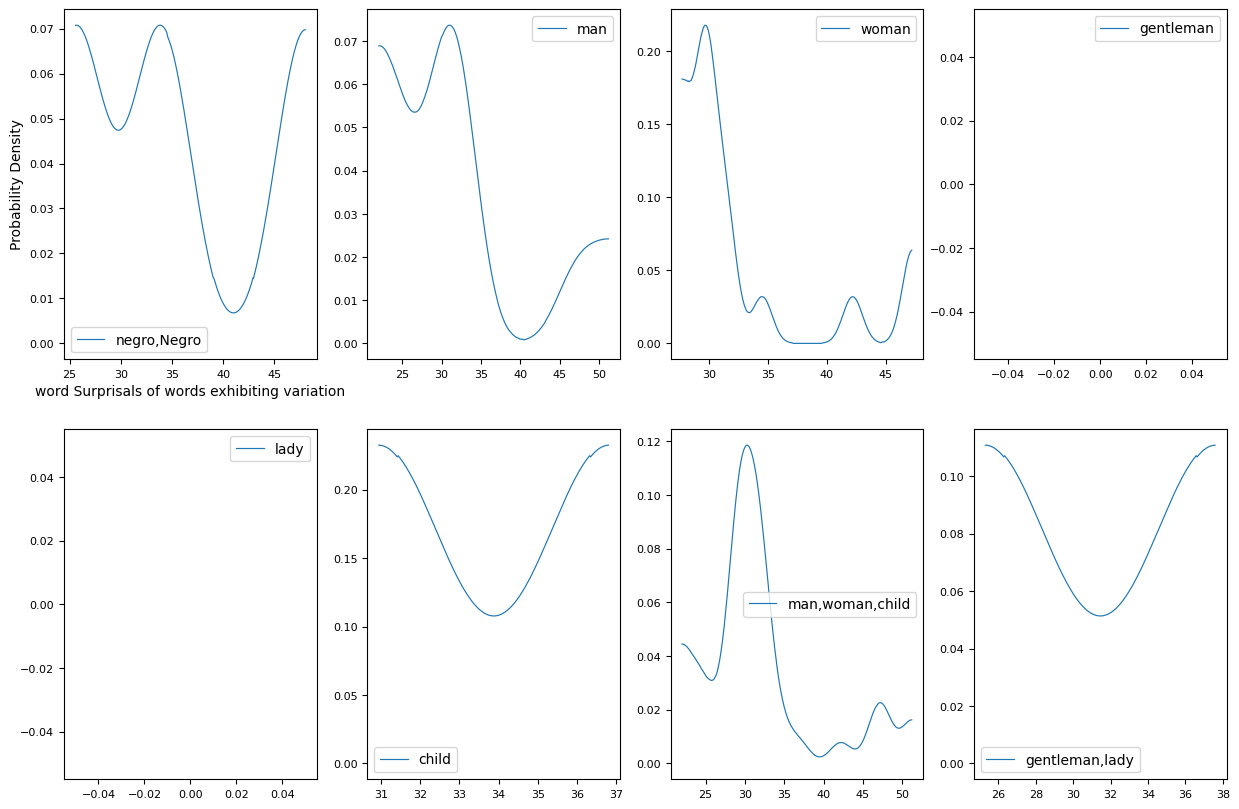

In [1052]:
variation = "a-"
surprisals = defaultdict(list)  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}
instances = {} 
# ------
# get the surprisals for all words demonstrative of the variation, for each speaker set
# ------

S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"]]
for speakers in S:
    surprisals[",".join(speakers)], instances[",".join(speakers)] = get_surprisals_for_variation(quotes, chains, variation, speakers)

# ------
# Get the MAS and newMAS for negro attributed quotation, where newMAS due to the absence of words showing the variation in question
# ------
speakers = ['negro', "Negro"]
i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))
print('negro,Negro', MAS_negro, newMAS_negro)

# ------
# get contribution of variation to observed difference between reference speaker attributed quotations and negro attributed quotations
# ------
for speakers in S[1:]:

    # get mAS and newMAS removed of variation for speakers
    i_of_interest = get_i_by_speakers(quotes, speakers, (0,1))
    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))

    # calculate the contribution of the variation to the observed mAS difference between n-word and reference speakers
    contribution = (MAS_negro - newMAS_negro) - (MAS - newMAS)
    relative_contribution = 100*contribution / (MAS_negro - MAS)
    print(speakers, contribution, relative_contribution)

# ------
# ;et's look at the plots of collection word (demonstrative of variation) surprisals
# ------
x,y = 2,3
fig, axs = plt.subplots(x, y, figsize=(15, 10))
for i, speakers in enumerate(S):

    row = i // y
    col = i - (row)*y
    az.plot_kde(np.array(surprisals[",".join(speakers)]), ax=axs[row, col], label=",".join(speakers), textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel(f"word Surprisals of words exhibiting {variation}")
        axs[row, col].set_ylabel("Probability Density")

## z -> d

wasn't, hasn't, artisans, prison (Z AH0 N) -> wadn't: i.e, find index of 's' in text that corresponds to (Z AH0 N), and replace 's' with 'd'

prisoner (Z AH0 N) -> pridner; i.e., find index of s corresponding to (Z AH0 N), and replace everything btween 's' and 'n' with 'dn'

doesn't (AH1 Z AH0 N) -> dudn't; i.e., find index of 'oesn' in text which is (AH1 Z AH0 N), and replace 'oesn' with 'udn'

business (Z N) --> bidness, ; find 's' that  corresponds to (Z N), and replace everything between 's' and 'n' with 'dn'
SSN, SN



In [521]:
# Load the CMU pronunciation dictionary
import requests
lines = requests.get("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b").text.splitlines()

# ignore eveything up the 'A  AH0'
lines = lines[lines.index('A  AH0'):]

In [526]:
# load unix dict
with open("/usr/share/dict/words", "r") as f:
    en_words = [x.strip("\n") for x in f.readlines()]

In [527]:
# expand en_words with DH variants
en_words += [line.split(" ")[0].lower() for line in lines] + [line.split(" ")[0].lower().capitalize() for line in lines]
en_words = set(en_words)

In [528]:
# get all words with DH
ZN = [line for line in lines if " Z AH0 N " in line] + [line for line in lines if " Z N " in line]
ZN

['ARKANSANS  AA2 R K AE1 N Z AH0 N Z',
 'ARTISANS  AA1 R T AH0 Z AH0 N Z',
 'BESANT  B EH1 Z AH0 N T',
 'BEZANSON  B EH1 Z AH0 N S AH0 N',
 'BIPARTISANSHIP  B AY0 P AA1 R T AH0 Z AH0 N SH IH2 P',
 'BOSENDORFER  B OW1 Z AH0 N D AO2 R F ER0',
 'BRAZENLY  B R EY1 Z AH0 N L IY0',
 'BRAZENNESS  B R EY1 Z AH0 N AH0 S',
 'BYZANTINE  B IH1 Z AH0 N T AY2 N',
 'BYZANTINE(1)  B IH1 Z AH0 N T IY2 N',
 'CAZENOVE  K AE1 Z AH0 N OW2 V',
 'CHAZANOFF  CH AE1 Z AH0 N AO0 F',
 'CHRZANOWSKI  CH ER2 Z AH0 N AO1 F S K IY0',
 "CITIZEN'S  S IH1 T AH0 Z AH0 N Z",
 'CITIZENRY  S IH1 T IH0 Z AH0 N R IY0',
 "CITIZENRY'S  S IH1 T IH0 Z AH0 N R IY0 Z",
 'CITIZENS  S IH1 T AH0 Z AH0 N Z',
 'CITIZENS(1)  S IH1 T IH0 Z AH0 N Z',
 "CITIZENS'  S IH1 T IH0 Z AH0 N Z",
 'CITIZENSHIP  S IH1 T IH0 Z AH0 N SH IH2 P',
 'COGNIZANCE  K AA1 G N AH0 Z AH0 N S',
 'COGNIZANT  K AA1 G N AH0 Z AH0 N T',
 "COUSIN'S  K AH1 Z AH0 N Z",
 'COUSINS  K AH1 Z AH0 N Z',
 'COUZENS  K UW1 Z AH0 N Z',
 'COZZENS  K AA1 Z AH0 N Z',
 'DEFEASANCE  D

In [529]:
# Expand DH to include variants of words where ING is replaced with IN'
display([" ".join([x.split(" ")[0][:-1] + "'"] + x.split(" ")[1:]) for x in ZN if x.split(" ")[0][-3:]=="ING"])
ZN += [" ".join([x.split(" ")[0][:-1] + "'"] + x.split(" ")[1:]) for x in ZN if x.split(" ")[0][-3:]=="ING"]

["IMPRISONIN'  IH2 M P R IH1 Z AH0 N IH0 NG",
 "POISONIN'  P OY1 Z AH0 N IH0 NG",
 "REASONIN'  R IY1 Z AH0 N IH0 NG",
 "RESONATIN'  R EH1 Z AH0 N EY2 T IH0 NG",
 "SEASONIN'  S IY1 Z AH0 N IH0 NG",
 "UNREASONIN'  AH0 N R IY1 Z N IH0 NG"]

In [2118]:
# build a word list variants, replacing th letters corresponding to DH sound, with ...
d = []
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    # get indices of 'th' positions in word
    th_indices = find_all_indices(word, 'TH')

    # order of occurrence of DH or TH sounds in ARPAbet representation
    th_sounds = [x for x in ARPAbet_rep if x == "DH" or x =='TH']

    # convert th letters corresponding to DH sound, as ...
    var1 = word  # th sounds like DH -> d
    var2 = word  ## th sounds like DH -> dd
    for i, th_sound in zip(th_indices, th_sounds):
        if th_sound == 'DH':
            var1 = var1[:i] + 'D' + var1[i+2:]  #this -> dis
            d.append(var1)
            var2 = var2[:i] + 'DD' + var2[i+2:]  #with -> widd
            d.append(var2)

# add variant, replacing OTH letters corresponding to "AH1 DH" sound, with "UDD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AH1', 'DH'])))>0:

        # get indices of 'oth' positions in word
        oth_indices = find_all_indices(word, 'OTH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AH1":
                th_sounds.append('AH1 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert oth letters corresponding to AH1 DH sound, as ...
        var1 = word  # th sounds like AH1 DH -> UDD
        for i, th_sound in zip(oth_indices, th_sounds):
            if th_sound == 'AH1 DH':
                var1 = var1[:i] + 'UDD' + var1[i+len('oth'):]  #this -> dis
                d.append(var1)

# add variant, replacing OTH letters corresponding to "AA1 DH" sound, with "ARD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AA1', 'DH'])))>0:

        # get indices of 'oth' positions in word
        ath_indices = find_all_indices(word, 'ATH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AA1":
                th_sounds.append('AA1 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert ath letters corresponding to AA1 DH sound, as ...
        var1 = word
        for i, th_sound in zip(ath_indices, th_sounds):
            if th_sound == 'AA1 DH':
                var1 = var1[:i] + 'ARD' + var1[i+len('ath'):]  #father -> farder
                d.append(var1)

# add variant, replacing OTH letters corresponding to "AA2 DH" sound, with "ARD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AA2', 'DH'])))>0:

        # get indices of 'oth' positions in word
        ath_indices = find_all_indices(word, 'ATH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AA2":
                th_sounds.append('AA2 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert ath letters corresponding to AA1 DH sound, as ...
        var1 = word
        for i, th_sound in zip(ath_indices, th_sounds):
            if th_sound == 'AA2 DH':
                var1 = var1[:i] + 'ARD' + var1[i+len('ath'):]  #father -> farder
                d.append(var1)

# # add variants where v --> b or bb
# d += [x.replace('v', 'b') for x in d if 'v' in x]
# d += [x.replace('v', 'bb') for x in d if 'v' in x]

# lowercase
d = [x.lower() for x in d]       
            
# get uppercase variants
d += [x.capitalize() for x in d]

# remove instances present in en_words
print(len(d))
d = set([x for x in d if x not in en_words])
print(len(d))

2648
2396


In [238]:
z.update(["bidness", "bidnessman", "bidnesswoman", "bidness's"])

In [239]:
"wadn't" in z

True

In [240]:
"idn't" in z

True

# RQ4

In [2106]:
len(quotes_all)

2379115

In [2139]:
for speakers in [["judge", "Judge"], ['blacksmith'], ['tanner'], ['doctor', 'Doctor'], ['preacher'], ['priest'],  ['servant'], ['hand'], ['farmer'],  ['miner'], ['worker'], ['convict', 'thief', 'murderer','criminal']]:
    q = quotes_all.loc[quotes_all.loc[:, 'speaker'].isin(speakers), 'quote']
    # print(q)
    print(speakers, len(q))

['judge', 'Judge'] 3284
['blacksmith'] 41
['tanner'] 1
['doctor', 'Doctor'] 5583
['preacher'] 326
['priest'] 673
['servant'] 256
['hand'] 3624
['farmer'] 370
['miner'] 155
['worker'] 9
['convict', 'thief', 'murderer', 'criminal'] 124


In [2145]:
# get quotation subset
quotes_RQ4 = quotes_all.loc[quotes_all.loc[:, 'speaker'].isin(['jugde', 'Judge', 'doctor', 'Doctor', 'farmer', 'hand', 'convict', 'criminal', 'thief', 'murderer']), :]

In [2146]:
quotes_RQ4.iloc[0]

id                                                      8711
p                                                        165
quote      "It is a favor that I have to ask of you. It i...
manner                                                  laid
speaker                                                 hand
i                                                        134
Name: 134, dtype: object

In [2227]:
# get corresponding blacklist
quotes_RQ4["words"] = quotes_RQ4.loc[:,"quote"].progress_apply(lambda x: get_words(x[1:-1]))
quotes_RQ4.loc[:,"i"] = list(range(len(quotes_RQ4)))
blacklist_RQ4 = [i for i, words in enumerate(quotes_RQ4.loc[:,'words']) if len(words) > 1024]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11138/11138 [00:00<00:00, 15622.27it/s]
/tmp/ipykernel_98299/3174195874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quotes_RQ4["words"] = quotes_RQ4.loc[:,"quote"].progress_apply(lambda x: get_words(x[1:-1]))
/tmp/ipykernel_98299/3174195874.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quotes_RQ4.loc[:,"i"] = list(range(len(quotes_RQ4)))


In [2228]:
blacklist_RQ4

[]

In [2153]:
# save the quotes
with open("RQ4_quotes.json", 'w') as f:
    json.dump(list(quotes_RQ4['quote']), f)

In [2189]:
# save the speakers
with open("RQ4_speakers.json", 'w') as f:
    json.dump(list(quotes_RQ4['speaker']), f)

answer RQ4

In [2274]:
quotes_RQ4 = quotes_RQ4.reset_index()

In [2190]:
# load the chains
with open("RQ4_chains_llama3.1_70B.json", 'r') as f:
    RQ4_chains = json.load(f)

In [2206]:
speaker2i = defaultdict(list)
for i, s in enumerate(quotes_RQ4['speaker']):
    speaker2i[s].append(i)

In [2208]:
speaker2i.keys()

dict_keys(['hand', 'doctor', 'Judge', 'Doctor', 'farmer', 'convict', 'thief', 'criminal', 'murderer'])

non--standard contractions

In [2276]:
quotes_RQ4['elision'] = quotes_RQ4['words'].progress_map(lambda words: [word for word in words if word not in en_words and interesting_apos(word, en_words)])
quotes_RQ4['elision_count'] = quotes_RQ4['elision'].progress_map(lambda words: len(words))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11138/11138 [00:00<00:00, 129568.79it/s]


In [2277]:
quotes_RQ4.loc[quotes_RQ4.loc[:,'elision_count']>0, :]

,index,id,p,quote,manner,speaker,i,words,elision,elision_count,AvSur
17,3697,15603,711,"""is that he doesn't attempt to disguise the ki...",added,Judge,17,"[is, that, he, doesn't, attempt, to, disguise,...",['Yes],1,0
32,7599,34801,2267,"""Hello, darlingest!--'Late as usual.' There--I...",extended,hand,32,"[Hello, ,, darlingest, !, --, 'Late, as, usual...",['Late],1,0
39,10928,52560,971,"""You might think from that, he was the first. ...",held,hand,39,"[You, might, think, from, that, ,, he, was, th...",[wa'n't],1,0
176,22544,14079,937,"""I've been out to the Meeches' all afternoon,""",said,doctor,176,"[I've, been, out, to, the, Meeches', all, afte...",[Meeches'],1,0
232,37461,16040,1620,"""she hadn't any. Old Craig senior left it all...",said,doctor,232,"[she, hadn't, any, ., Old, Craig, senior, left...",['Tisn't],1,0
...,...,...,...,...,...,...,...,...,...,...,...
11005,2365759,40814,588,"""shouldn't think they were--blue eyes--sanguin...",said,doctor,11005,"[shouldn't, think, they, were, --, blue, eyes,...",['em],1,0
11014,2366207,40814,940,"""Sh-sh. 'It--is es-ti-ma-ted by Captain Smith-...",said,doctor,11014,"[Sh-sh, ., 'It, --, is, es-ti-ma-ted, by, Capt...","['It, up'ards]",2,0
11025,2366662,40814,1339,"""the water has overflowed the cellar, and got ...",said,doctor,11025,"[the, water, has, overflowed, the, cellar, ,, ...",[sp'iled],1,0
11049,2368374,51925,1058,"""Ah yo' de gennleman known ter dis hyah sinful...",asts,doctor,11049,"[Ah, yo', de, gennleman, known, ter, dis, hyah...",[Docto'],1,0


In [2291]:
# socio lingustic counterpoints
quotes_RQ4.loc[:, 'AvSur'] = 0
variation = 'elision'
for speakers in [['jugde', 'Judge'], ['doctor', 'Doctor'], ['farmer'], ['hand'], ['convict', 'criminal', 'thief', 'murderer']]:

    I = get_i_by_speakers(quotes_RQ4, speakers, (0,1))

    variation_surprisals, variation_instances = get_surprisals_for_variation(quotes_RQ4, RQ4_chains, 'elision', speakers)

    print(speakers, sum(variation_surprisals) / len(I))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1437/1437 [00:00<00:00, 3459.24it/s]


['jugde', 'Judge'] 0.8265023957890536


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5583/5583 [00:01<00:00, 4653.23it/s]


['doctor', 'Doctor'] 0.700044126637263


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 370/370 [00:00<00:00, 4075.96it/s]


['farmer'] 4.423036806002244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3624/3624 [00:01<00:00, 2942.92it/s]


['hand'] 3.663822823104853


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 2942.32it/s]

['convict', 'criminal', 'thief', 'murderer'] 1.8228279065762867


In [2295]:
# original counterpoints
variation = 'elision'
for speakers in [['negro', 'Negro'], ['man'], ['lady'], ['child']]:

    I = get_i_by_speakers(quotes, speakers, (0,1))

    variation_surprisals, variation_instances = get_surprisals_for_variation(quotes, chains, 'elision', speakers)

    print(speakers, sum(variation_surprisals) / len(I))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 816/816 [00:00<00:00, 2090.36it/s]


['negro', 'Negro'] 12.98088543978049


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15178/15178 [00:03<00:00, 4872.81it/s]


['man'] 4.188768818766479


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3996/3996 [00:00<00:00, 4757.28it/s]


['lady'] 1.3116481433168496


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 933/933 [00:00<00:00, 4646.07it/s]

['child'] 2.04507138495756


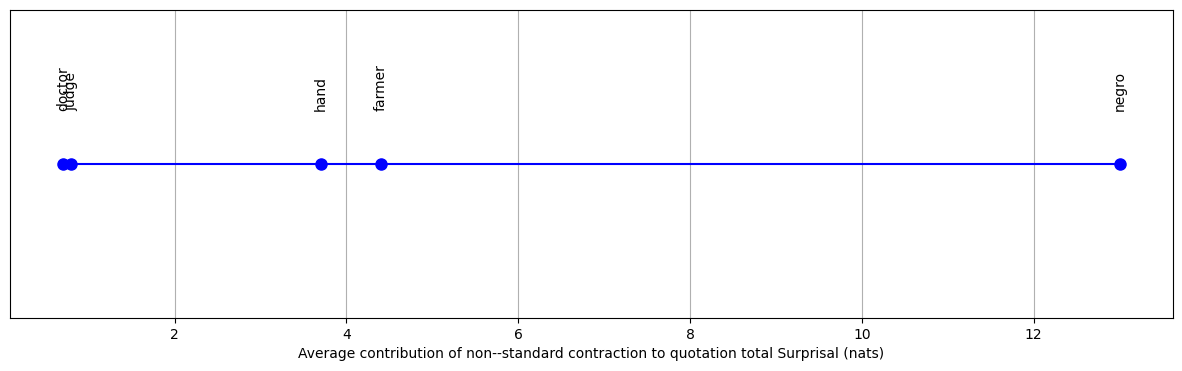

In [2302]:
import matplotlib.pyplot as plt

# Sample singular values
singular_values = [13.0, 4.4, 3.7, 0.8, 0.7]
labels = ['negro', 'farmer', 'hand', 'judge', 'doctor']

# Create a figure and plot a line with points
plt.figure(figsize=(15, 4))

# Plot the singular values as a line with points
plt.plot(singular_values, [1] * len(singular_values), 'bo-', markersize=8)

# Annotate each point with its label
for i, label in enumerate(labels):
    plt.text(singular_values[i], 1.02, label, ha='center', rotation=90)

# Add labels and title
plt.xlabel('Average contribution of non--standard contraction to quotation total Surprisal (nats)')
plt.yticks([])  # Hide y-axis ticks since we don't need them

# Add grid for the x-axis
plt.grid(True, axis='x')

plt.savefig('RQ4_distance')
# Show the plot
plt.show()


# Representing out of dictionary text in terms of CMU pronunciation


Can I use the CMU dictionary as the basis for predicting how some snippet of letters may correspond to CMU prounciation?

why is this interesting? what is we could identify out of dictionary words (which represent our instances of non-standard prounciation), identify which word they are approximating, compare the CMU arpabet translation between the correct and non--standard form, and therefore identify the transformations that have taken place.


In [52]:
# import
import requests
lines = requests.get("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b").text.splitlines()

# ignore eveything up the 'A  AH0'
lines = lines[lines.index('A  AH0'):]

# ignore stresses as deep phenomizer doesnt have these
word2arpa = defaultdict(list)
for line in lines:
    splits = [split for split in line.split(" ") if split != '']
    word = splits[0].split('(')[0]
    arpa = "".join(['[' + split.translate(str.maketrans('', '', '0123456789')) + ']' for split in splits[1:]])
    word2arpa[word].append(arpa)


In [53]:
word2arpa["ALEX'S"]

['[AE][L][AH][K][S][IH][Z]']

Deep Phonemizer

In [46]:
# load dp
from dp.phonemizer import Phonemizer
phonemizer = Phonemizer.from_checkpoint('./en_us_cmudict_forward.pt')
phonemizer('junction', lang='en_us')

/home/ry/miniconda3/envs/70B/lib/python3.11/site-packages/dp/model/model.py:306: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_l

'[JH][AH][NG][K][SH][AH][N]'

In [66]:
phonemizer("gettin'", lang='en_us')

'[G][IH][T][AH][N]'

In [67]:
word2arpa['GETTING']

['[G][EH][T][IH][NG]', '[G][IH][T][IH][NG]']

In [49]:

found = []
for original, annotated, i in annotations[:40]:  # first 40 have been annotated
    for x in re.findall("#[^#]*#[^#]*#[^#]*#", annotated):
        found.append((i,x))

print(len(set([i for i,x in found])))

# ordered by original word
for i,x in sorted(found, key = lambda x: x[1].split('#')[1]):
    print(i,x)

32
331 #'bout#about#dropped AH0 at start#
7834 #'bout#about#dropped A at start#
22406 #'em#them#dropped TH at beginning#
24620 #'em#them#dropped DH at start#
10993 #'fernal#infernal#dropped IH2_N at start#
17329 #'im#him#dropped H at start#
9145 #'pinion#opinion#dropped AH0 start#
10459 #'teak#steak#dropped S at start#
20092 #'way#away#dropped AH0 from start#
22406 #<MISSING>#have#missing aux verb#
24620 #<MISSING>#is#missing linking verb#
24353 #<MISSING>#as#missing conjunction#
24353 #<MISSING>#are#missing linking verb#
24421 #<MISSING>#are#missing verb#
331 #<MISSING>#a#missing determiner, missing indefinite article#
7834 #Ah#I#AY1->AA1#
331 #An'#end#dropped D at end#
22406 #Dat#That#th->d#
331 #Den#Then#DH->D#
330 #Dis#This#DH->D#
14999 #Feedin'#Feeding#dropped g at end#
9145 #Giner'l#General#EH1->IH1,dropped AH0#
6803 #I'se#I am#non--standard contraction#
9145 #Injun#Indian#D->JH, IY0_AH0->AH1#
6803 #Mars'#Master#dropped T_ER0 from end#
6803 #Mars'#Master#dropped T_ER0 from end#
2

other thoughts:
 - what are the RQ3 contribs for out of dict words? (gives an upperbound estimate of what can be achieved)
 - can we separate out e.g., in' endings and ' starts?
 - would be great to find a decent correction tool to auto-identify the original word, and compare arpa rep!
 - would be great to confirm what textbooks tell us. what did folgert send?

# (non--standard) spelling correction

In [3]:
import neuspell

data folder is set to `/home/ry/miniconda3/envs/70B/lib/python3.11/site-packages/neuspell/../data` script


In [18]:
checker = neuspell.BertChecker()
checker.from_pretrained()

loading vocab from path:/home/ry/miniconda3/envs/70B/lib/python3.11/site-packages/neuspell/../data/checkpoints/subwordbert-probwordnoise/vocab.pkl
initializing model
SubwordBert(
  (bert_dropout): Dropout(p=0.2, inplace=False)
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0

UnpicklingError: invalid load key, '<'.

In [80]:
# Load the pre-trained model


# Define your sentence and the specific words to correct
sentence = "I love the rain an' it is so refreshing"
words_to_correct = ["an'"]  # Words you want to correct

# Split sentence into words
words = sentence.split()

# Check and correct only specific words
corrected_words = [checker.correct(word) if word in words_to_correct else word for word in words]

# Join corrected words back into a sentence
corrected_sentence = ' '.join(corrected_words)

print("Original sentence:", sentence)
print("Corrected sentence:", corrected_sentence)

Original sentence: I love the rain an' it is so refreshing
Corrected sentence: I love the rain airliners Particularly it is so refreshing
